In [382]:
pip install -U keras-tuner

   ---------------------------------------- 0.0/129.1 kB ? eta -:--:--
   --- ------------------------------------ 10.2/129.1 kB ? eta -:--:--
   --------- ----------------------------- 30.7/129.1 kB 435.7 kB/s eta 0:00:01
   ------------------------ -------------- 81.9/129.1 kB 762.6 kB/s eta 0:00:01
   -------------------------------------- 129.1/129.1 kB 951.3 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Activation, SimpleRNN, Input,Reshape, GRU, Dropout, Bidirectional, BatchNormalization, LeakyReLU,RepeatVector,TimeDistributed
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from keras.regularizers import l1
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
df = pd.read_csv('C:/Users/LEONSAM/Downloads/test.csv', decimal=',')
df.set_index('Unnamed: 0', inplace=True)
df.index = pd.to_datetime(df.index)
HISTORY_SIZE = 60
TARGET_SIZE = 30
STEP = 1
BUFFER_SIZE = 512
BATCH_SIZE = 512
df = df.astype(np.float32)



df = df.drop('OneRoomRemainLess37', axis=1)
df = df.drop('AverageSpacedesign2', axis=1)
df = df.drop('AverageSpacedesign3', axis=1)
df = df.drop('AverageSpacedesign', axis=1)
df = df.drop('ActiveCount', axis=1)

df['is_winter'] = (pd.to_datetime(df.index).month.isin([12, 1, 2])).astype(int)
df['is_spring'] = (pd.to_datetime(df.index).month.isin([3, 4, 5])).astype(int)
df['is_summer'] = (pd.to_datetime(df.index).month.isin([6, 7, 8])).astype(int)
df['is_fall'] = (pd.to_datetime(df.index).month.isin([9, 10, 11])).astype(int)
df['is_weekend'] = ((pd.to_datetime(df.index).month == 5) & (pd.to_datetime(df.index).day.isin([1, 2, 3, 4, 9])) | (pd.to_datetime(df.index).month == 1) & (pd.to_datetime(df.index).day.isin([1, 2, 3])) | (pd.to_datetime(df.index).dayofweek >= 5)).astype(int)

tf.random.set_seed(25)


df

,CountContracts,CountContracts2,CountContracts3,tisa_FloorminMore37,tisa_FloormaxMore37,tisa_FlooravgMore37,tisa_QuantityavgMore37,OneRoomRemainMore37,TwoRoomFloormin,TwoRoomFloormax,...,c,calls2,calls3,kr,Цена,is_winter,is_spring,is_summer,is_fall,is_weekend
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,0.0,1.0,23.0,8.0,45.513809,357.0,1.0,25.0,...,0.0,0.0,0.0,5.5,30.587999,1,0,0,0,1
2013-01-02,0.0,0.0,0.0,1.0,23.0,8.0,45.513809,357.0,1.0,25.0,...,0.0,0.0,0.0,5.5,30.174999,1,0,0,0,1
2013-01-03,0.0,0.0,0.0,1.0,23.0,8.0,45.513809,357.0,1.0,25.0,...,0.0,0.0,0.0,5.5,30.250000,1,0,0,0,1
2013-01-04,0.0,0.0,0.0,1.0,23.0,8.0,45.513809,357.0,1.0,25.0,...,13.0,14.0,4.0,5.5,30.327999,1,0,0,0,0
2013-01-05,0.0,0.0,0.0,1.0,23.0,8.0,45.513809,357.0,1.0,25.0,...,15.0,6.0,5.0,5.5,30.334999,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,0.0,3.0,0.0,2.0,25.0,12.0,42.947205,161.0,2.0,25.0,...,1.0,0.0,0.0,16.0,91.720001,0,1,0,0,0
2024-04-27,1.0,0.0,3.0,2.0,25.0,12.0,42.936249,160.0,2.0,25.0,...,0.0,2.0,0.0,16.0,92.397499,0,1,0,0,1
2024-04-28,0.0,0.0,0.0,2.0,25.0,12.0,42.936249,160.0,2.0,25.0,...,2.0,1.0,0.0,16.0,92.698753,0,1,0,0,1


In [351]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CountContracts,4138.0,0.536491,0.972798,0.000000,0.000000,0.000000,1.000000,13.000000
CountContracts2,4138.0,0.552199,0.952995,0.000000,0.000000,0.000000,1.000000,9.000000
CountContracts3,4138.0,0.429676,0.856664,0.000000,0.000000,0.000000,1.000000,25.000000
ActiveCount,4138.0,14.979217,28.031864,0.000000,0.000000,5.000000,18.000000,474.000000
AverageSpacedesign,4138.0,13.667277,20.537304,0.000000,0.000000,0.000000,39.941250,82.199997
AverageSpacedesign2,4138.0,22.506252,33.506546,0.000000,0.000000,0.000000,59.900002,253.100006
AverageSpacedesign3,4138.0,30.482994,49.022629,0.000000,0.000000,0.000000,80.745832,237.300003
tisa_FloorminMore37,4138.0,1.194780,0.396079,1.000000,1.000000,1.000000,1.000000,2.000000
tisa_FloormaxMore37,4138.0,27.199371,1.524636,23.000000,28.000000,28.000000,28.000000,28.000000
tisa_FlooravgMore37,4138.0,10.734413,1.294932,8.000000,10.000000,11.000000,12.000000,13.000000


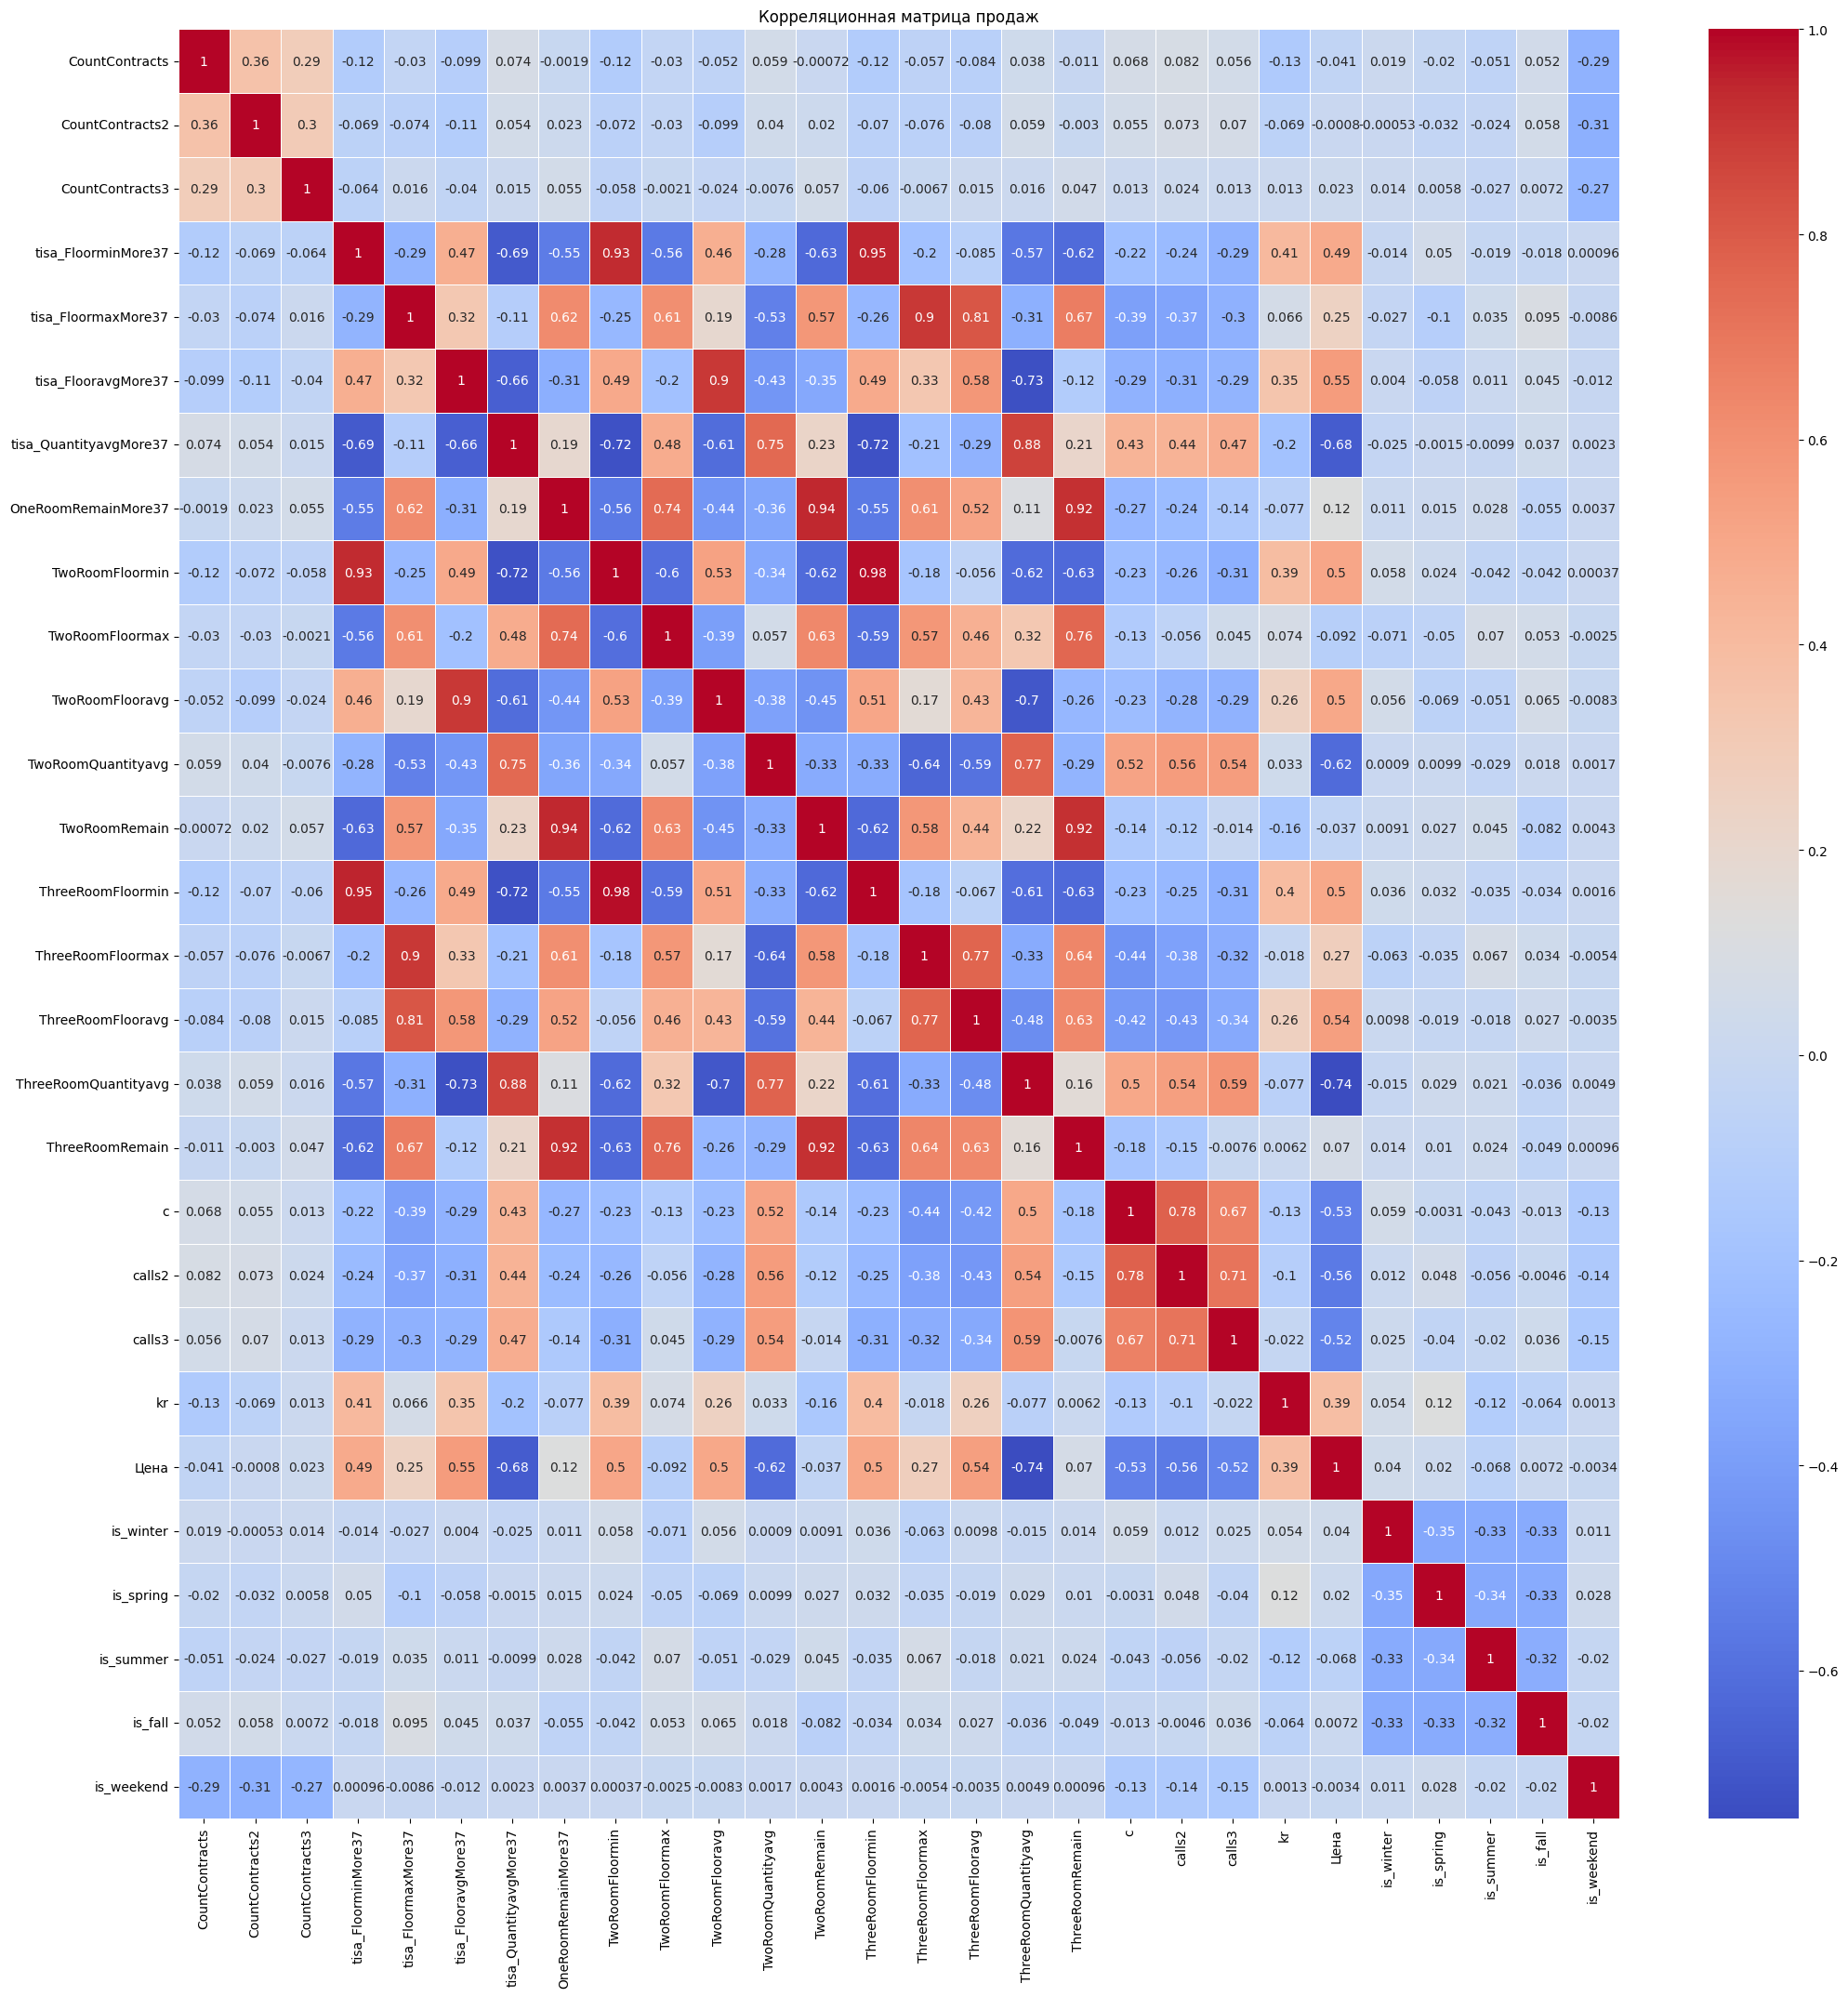

In [5]:
# Вычисление корреляций между продажами
correlation_matrix = df.corr()
# Визуализация корреляционной матрицы
import seaborn as sns

plt.figure(figsize=(25, 25))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Корреляционная матрица продаж')
plt.show()

In [6]:
def create_time_steps(length):
  return list(range(-length, 0))

In [193]:
predictedCheck = []
actualCheck = []

In [50]:
def multivariate_multioutput_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False, dates=None):
    data = []
    labels = []
    data_dates = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        indicesDT = range(i-history_size, i+30, step)
        if dates is not None:
            data_dates.append(dates[indicesDT])
        
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data)[:,:,:], np.array(labels)[:,:,:], np.array(data_dates)

def multi_step_output_plot(history, true_future, prediction, history_dates):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    
    normHistory = np.round(scalerY.inverse_transform(history[:,:3].reshape(60,3)))
    normFuture = np.round(scalerY.inverse_transform(true_future.reshape(30,3)))
    #for i, (var, c) in enumerate(zip(df.columns[:3], ['b','r','k'])):
    for i, (var, c) in enumerate(zip(df.columns[0:1], ['r','b','g'])):
        i=i
        plt.plot(history_dates[:HISTORY_SIZE], np.array(normHistory[:, i]), c, label=f"{i+1}к кв")
        plt.plot(history_dates[HISTORY_SIZE:], np.array(normFuture[:,i]), c, markersize=5, alpha=0.5,
               label=f"Реальное значение {i+1}к кв")
        if prediction.any():
            normPred = np.round(scalerY.inverse_transform(prediction.reshape(30,3)))
            plt.plot(history_dates[HISTORY_SIZE:], np.array(normPred[:,i]), #'*', markersize=5, alpha=0.5,
                     label=f"Прогноз {i+1}к кв")
            print('true',np.array(normFuture[:,i]).sum(),' pred',np.array(normPred[:,i]).sum())
            predictedCheck.append(np.array(normPred[:,0]).sum())
            actualCheck.append(np.array(normFuture[:,0]).sum())
    plt.legend(loc='upper left')
    plt.show()

In [19]:


# Создание экземпляров MinMaxScaler для X и Y
scalerX = MinMaxScaler()
scalerY = MinMaxScaler()

# Нормализация данных для X и Y
DFY = df[['CountContracts','CountContracts2','CountContracts3' ]]
DFY_normalized = pd.DataFrame(scalerY.fit_transform(DFY), index=df.index)  # Сохранение индекса даты
DFX = df[df.columns[3:]]
DFX_normalized = pd.DataFrame(scalerX.fit_transform(DFX), index=df.index)  # Сохранение индекса даты

# Конкатенация нормализованных данных
normalized_df = pd.concat([DFY_normalized, DFX_normalized], axis=1)
normalized_df.columns = range(normalized_df.shape[1])
normalized_df


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.000000,0.000000,0.00,0.0,0.0,0.0,0.747316,0.260526,0.0,0.0,...,0.000000,0.000000,0.000000,0.079365,0.006408,1.0,0.0,0.0,0.0,1.0
2013-01-02,0.000000,0.000000,0.00,0.0,0.0,0.0,0.747316,0.260526,0.0,0.0,...,0.000000,0.000000,0.000000,0.079365,0.002758,1.0,0.0,0.0,0.0,1.0
2013-01-03,0.000000,0.000000,0.00,0.0,0.0,0.0,0.747316,0.260526,0.0,0.0,...,0.000000,0.000000,0.000000,0.079365,0.003421,1.0,0.0,0.0,0.0,1.0
2013-01-04,0.000000,0.000000,0.00,0.0,0.0,0.0,0.747316,0.260526,0.0,0.0,...,0.025641,0.053435,0.086957,0.079365,0.004110,1.0,0.0,0.0,0.0,0.0
2013-01-05,0.000000,0.000000,0.00,0.0,0.0,0.0,0.747316,0.260526,0.0,0.0,...,0.029586,0.022901,0.108696,0.079365,0.004172,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-26,0.000000,0.333333,0.00,1.0,0.4,0.8,0.218484,0.002632,1.0,0.0,...,0.001972,0.000000,0.000000,0.746032,0.546744,0.0,1.0,0.0,0.0,0.0
2024-04-27,0.076923,0.000000,0.12,1.0,0.4,0.8,0.216226,0.001316,1.0,0.0,...,0.000000,0.007634,0.000000,0.746032,0.552733,0.0,1.0,0.0,0.0,1.0
2024-04-28,0.000000,0.000000,0.00,1.0,0.4,0.8,0.216226,0.001316,1.0,0.0,...,0.003945,0.003817,0.000000,0.746032,0.555395,0.0,1.0,0.0,0.0,1.0


In [219]:
x_train_multi_scaled.shape

(2940, 60, 28)

In [20]:
dates1 = normalized_df.index
x_train_multi_scaled, y_train_multi_scaled, train_dates = multivariate_multioutput_data(normalized_df.values, normalized_df.values[:,:3], 0,
                                                 3000, HISTORY_SIZE,
                                                 TARGET_SIZE, STEP, dates=dates1)
x_val_multi_scaled, y_val_multi_scaled, val_dates = multivariate_multioutput_data(normalized_df.values, normalized_df.values[:, :3],
                                             3000, None, HISTORY_SIZE,
                                             TARGET_SIZE, STEP, dates=dates1)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi_scaled, y_train_multi_scaled))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi_scaled, y_val_multi_scaled))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

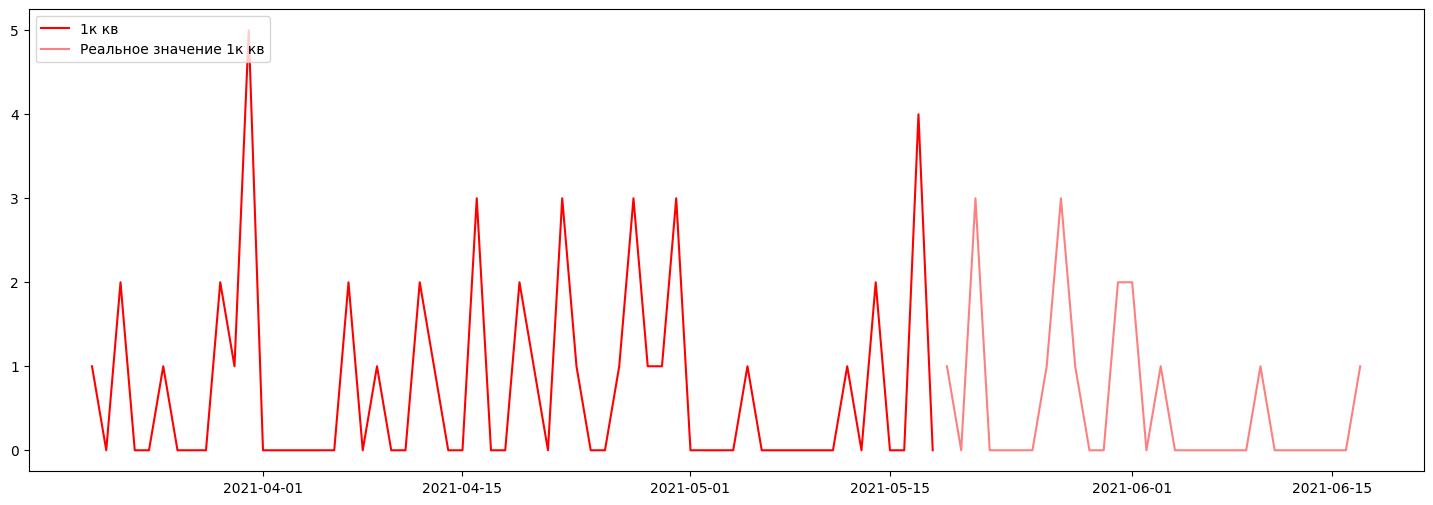

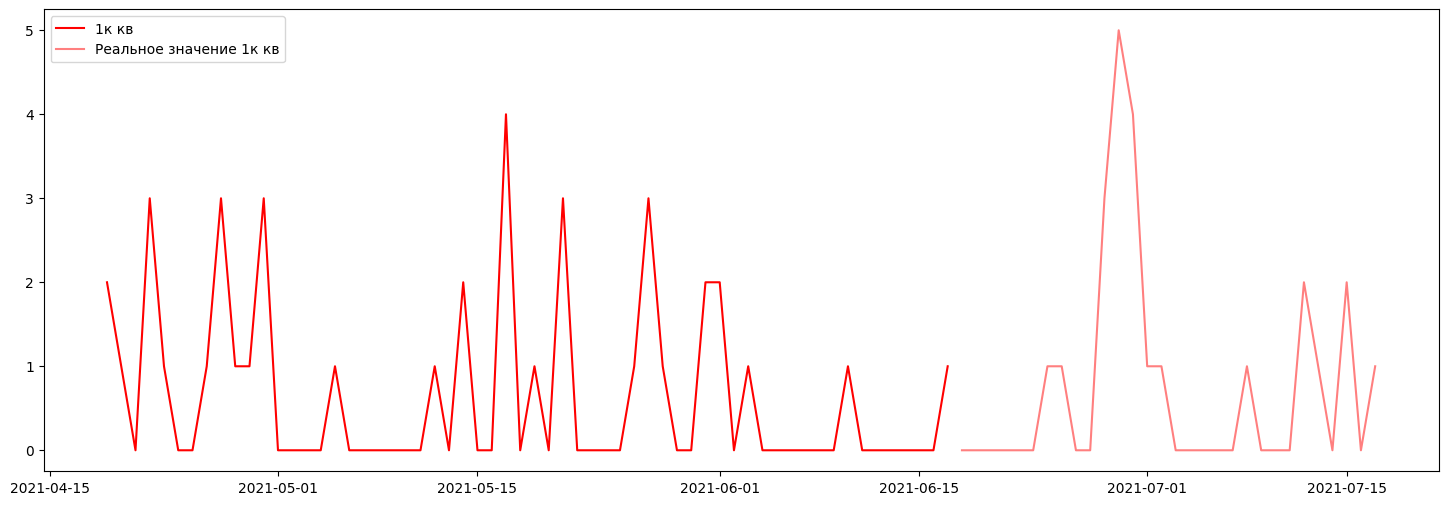

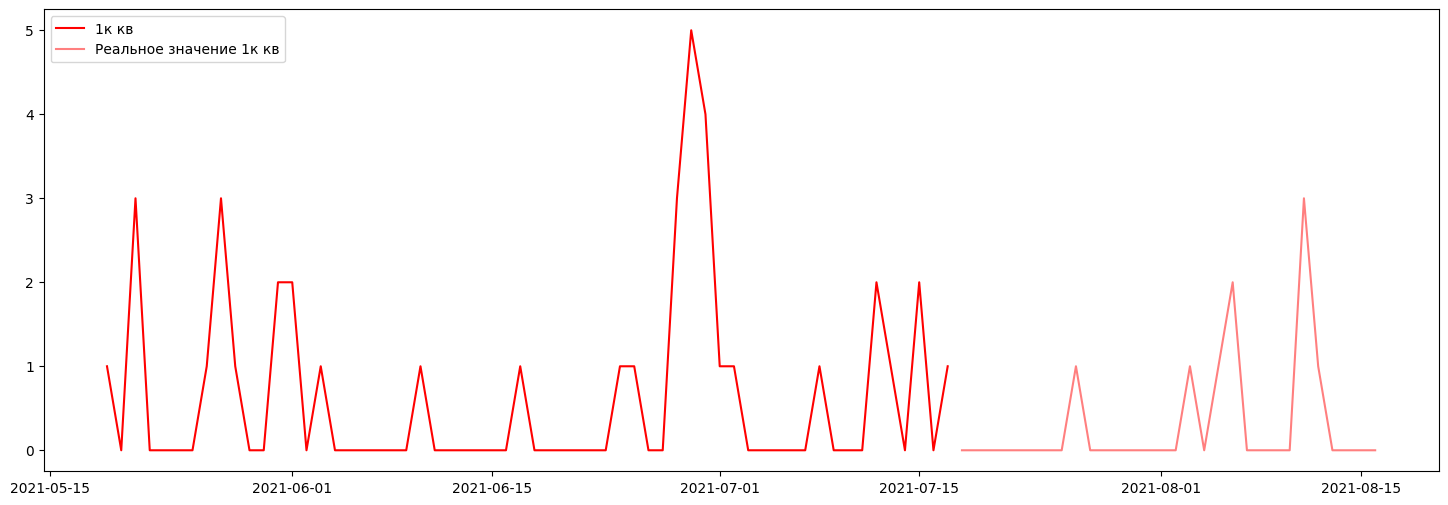

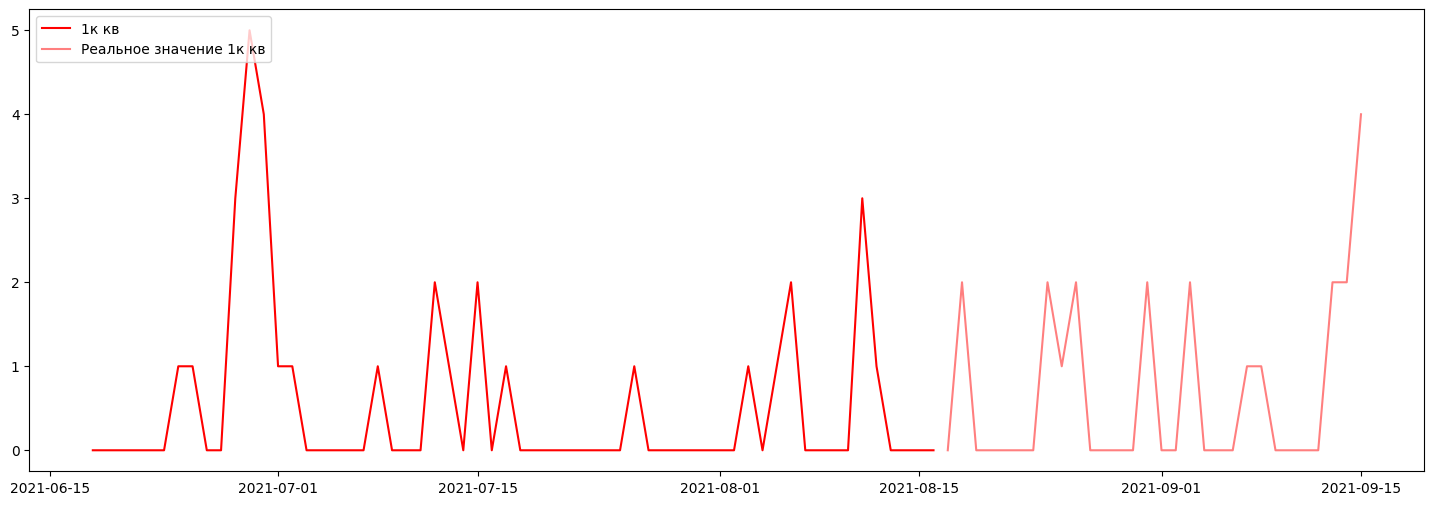

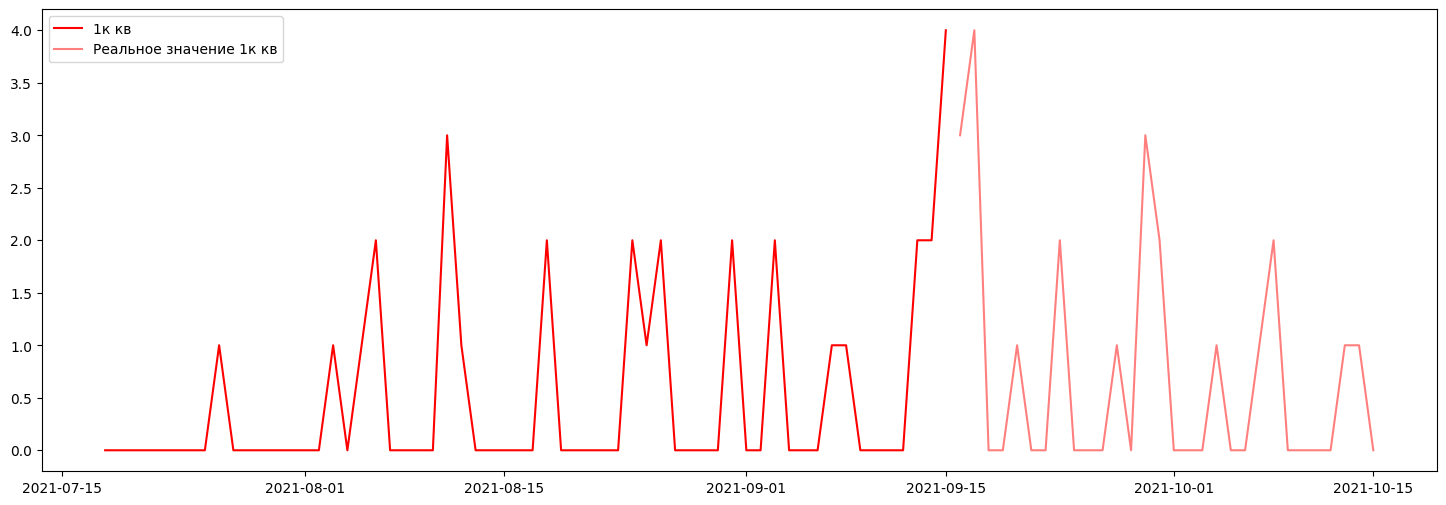

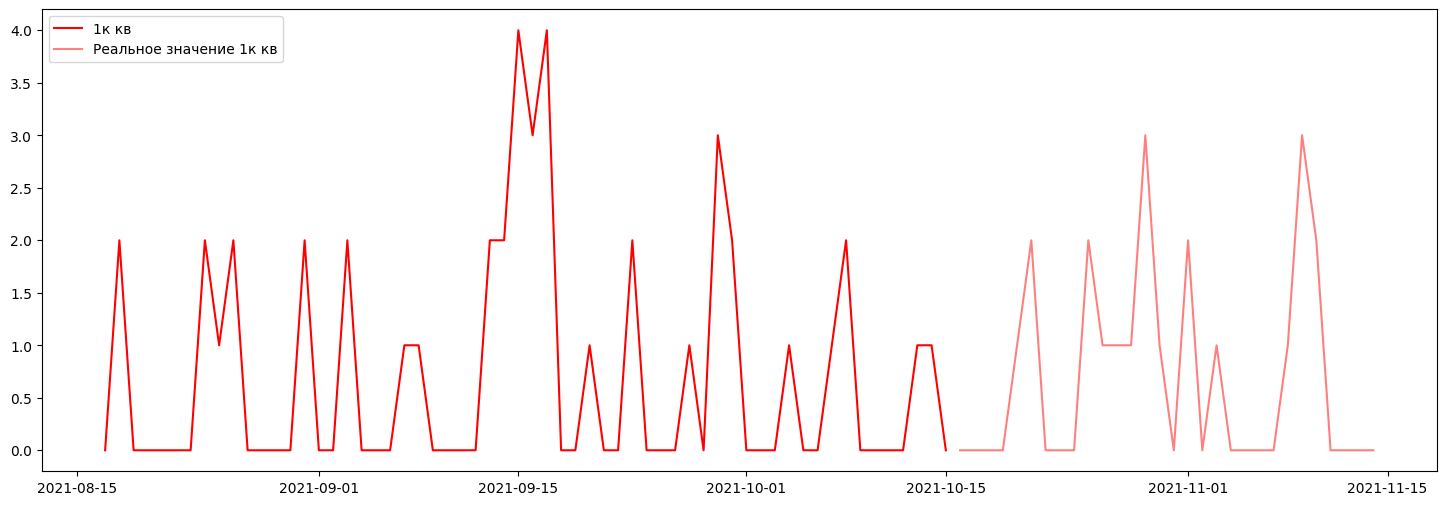

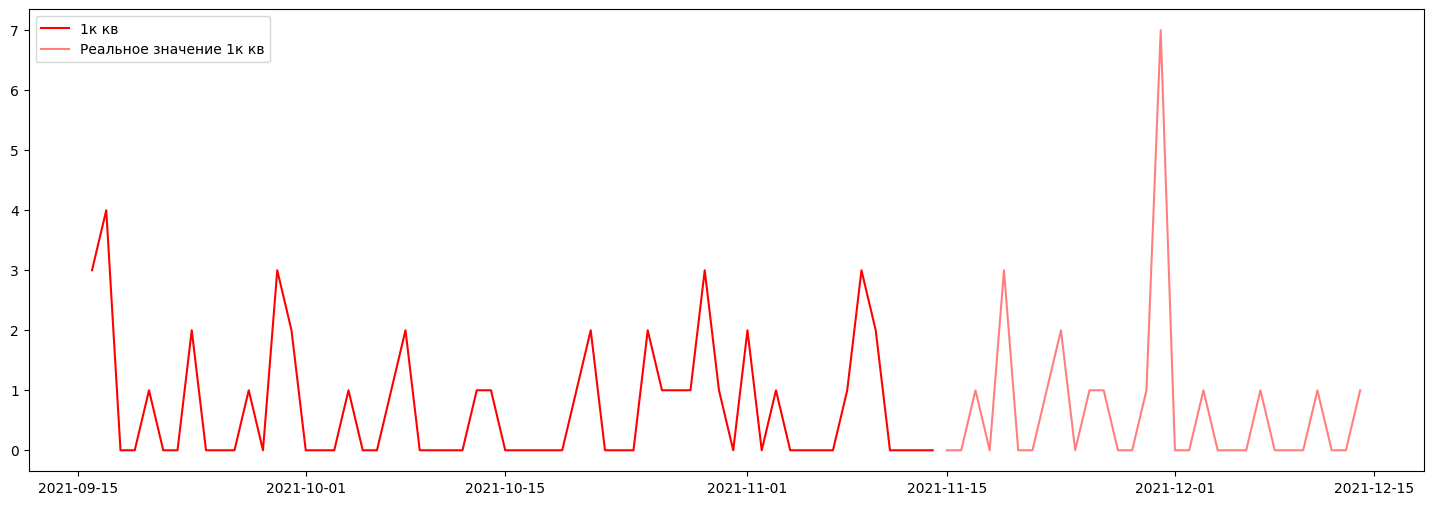

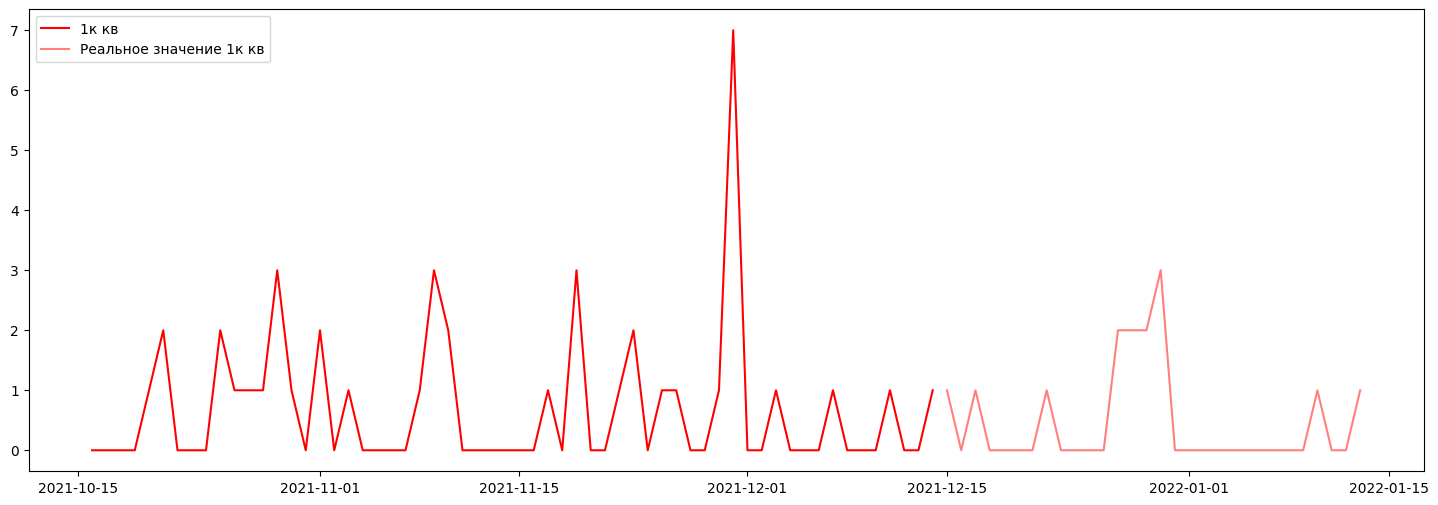

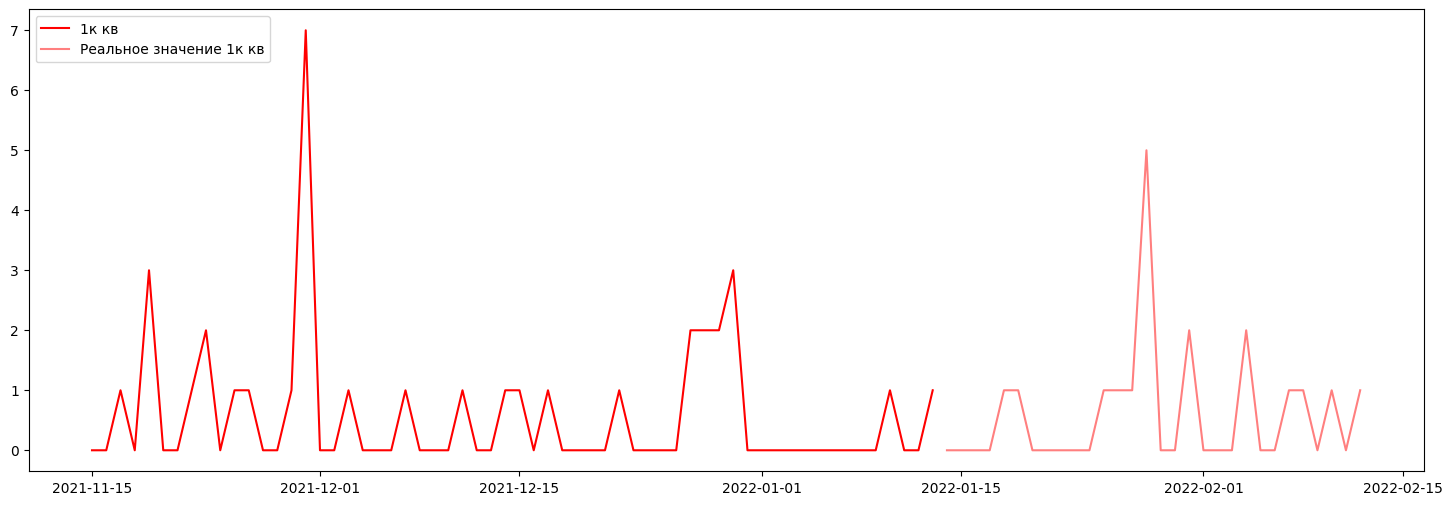

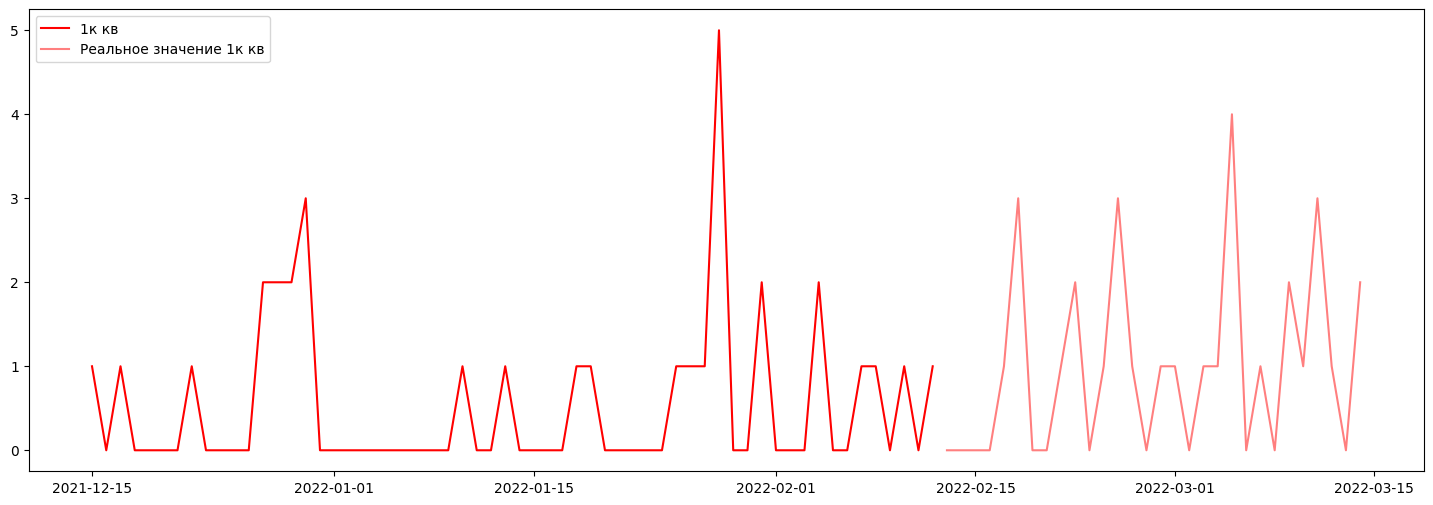

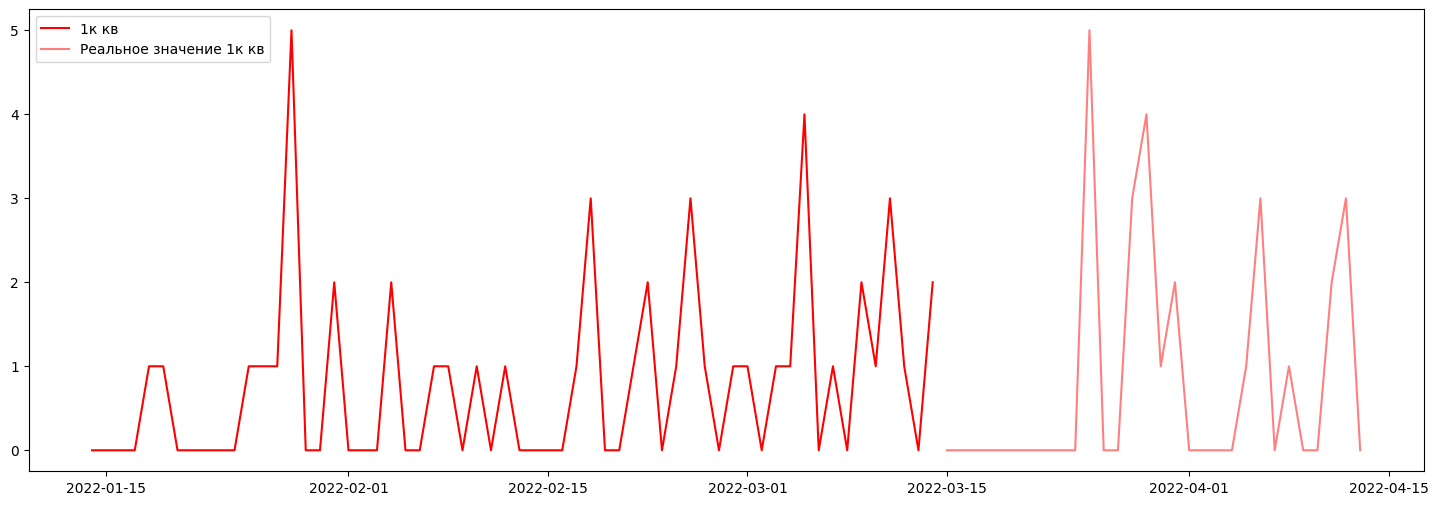

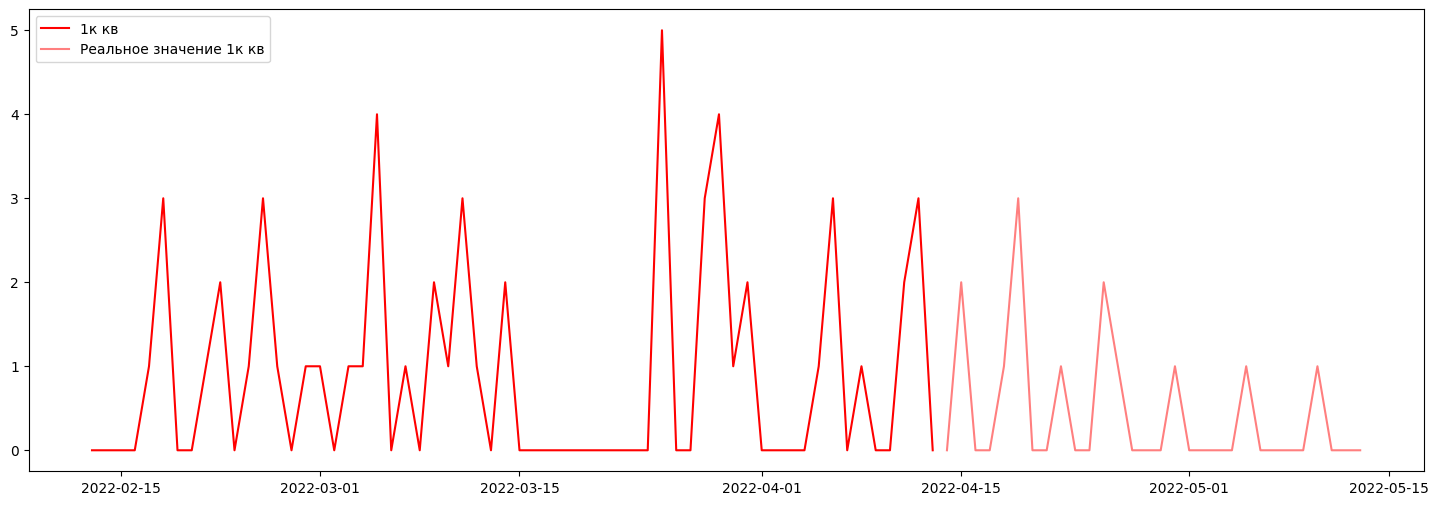

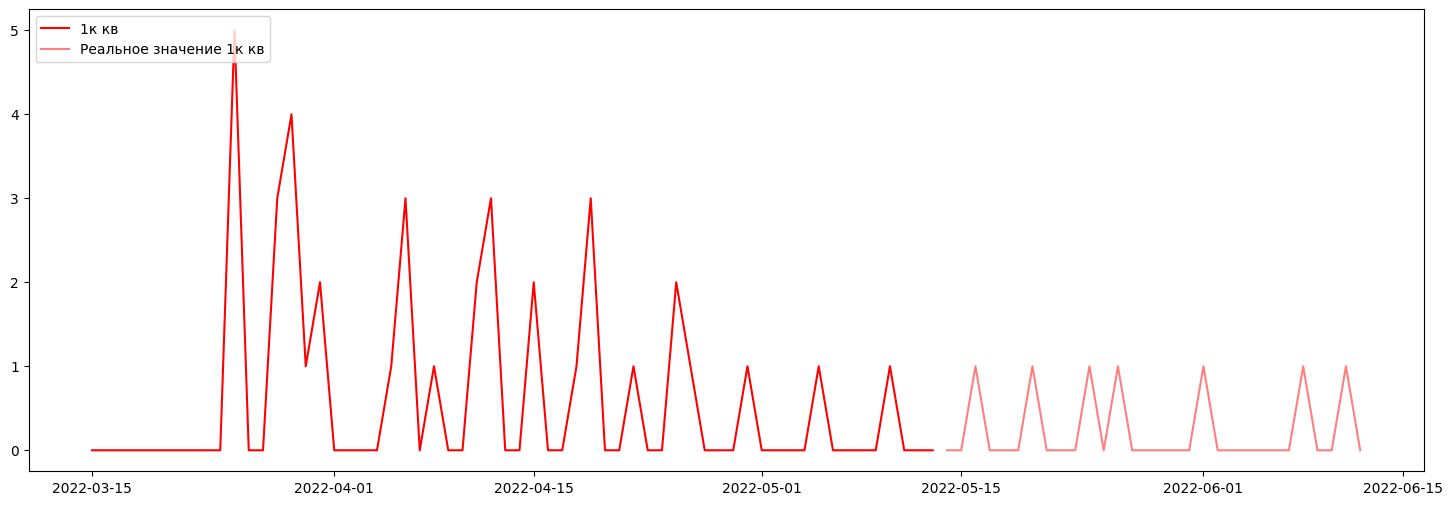

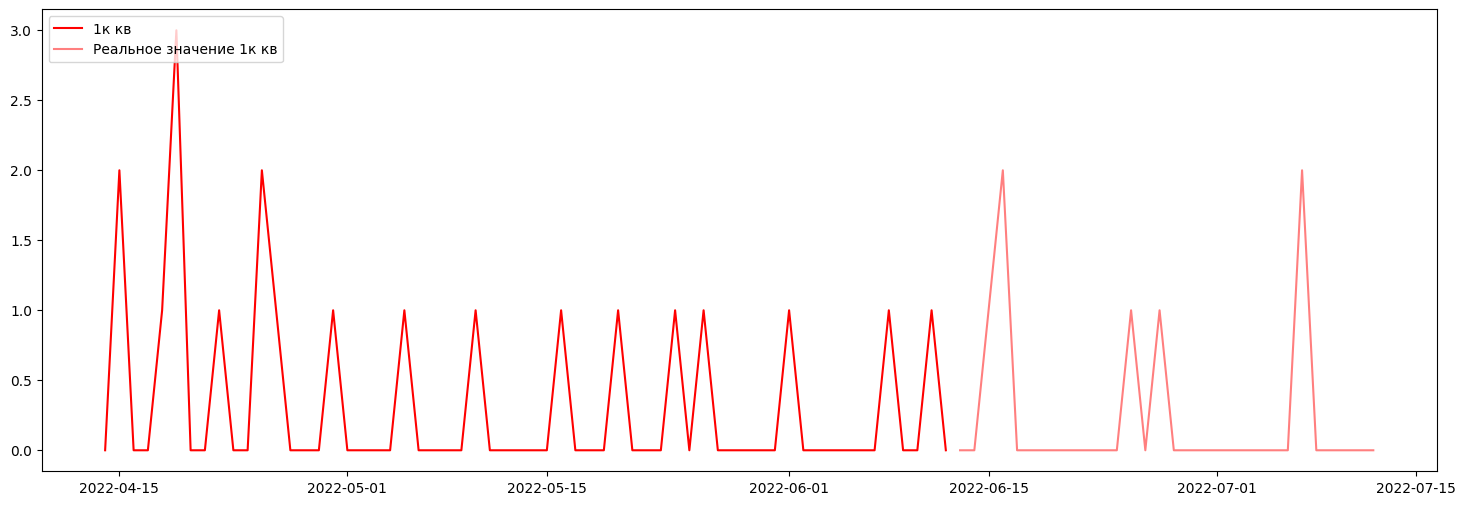

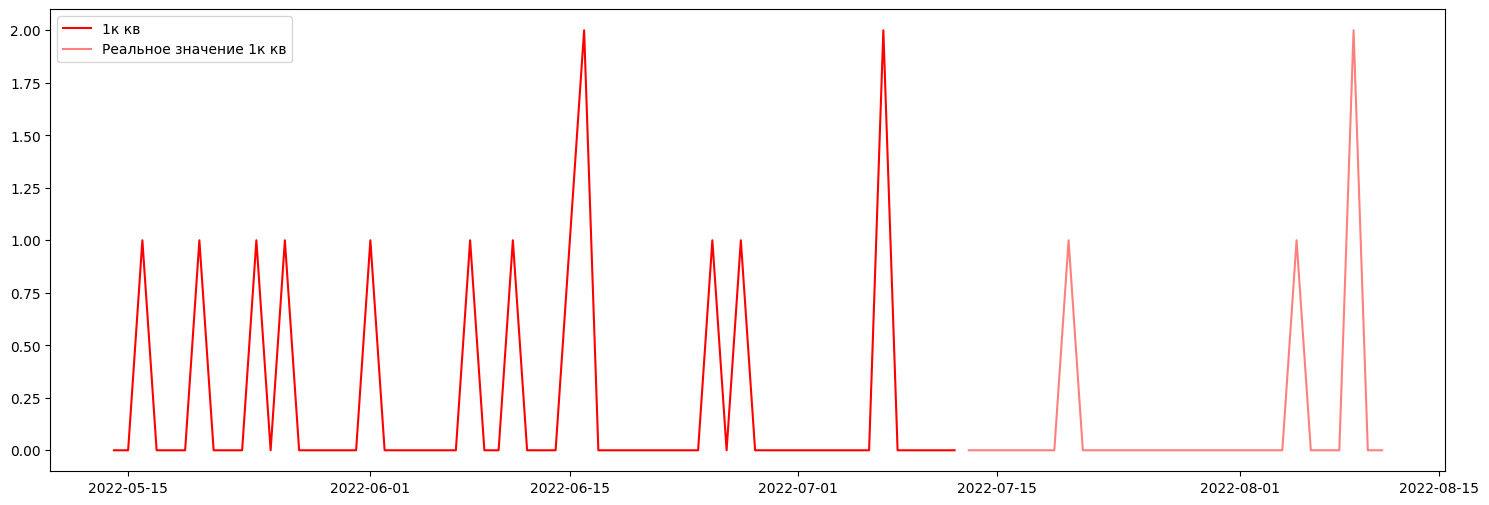

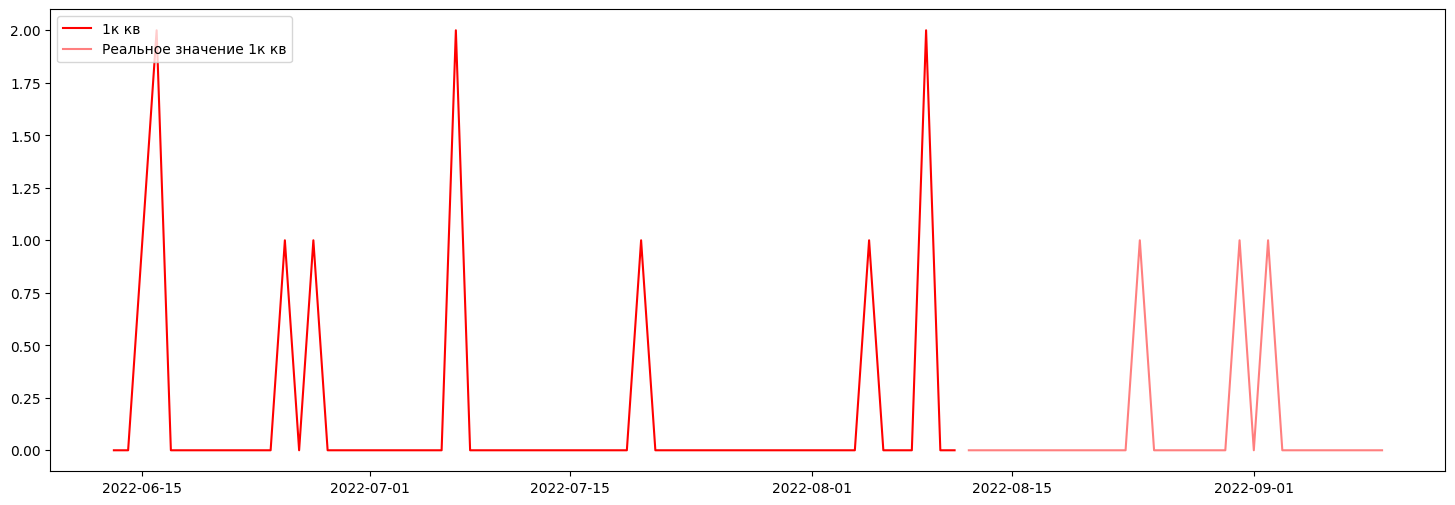

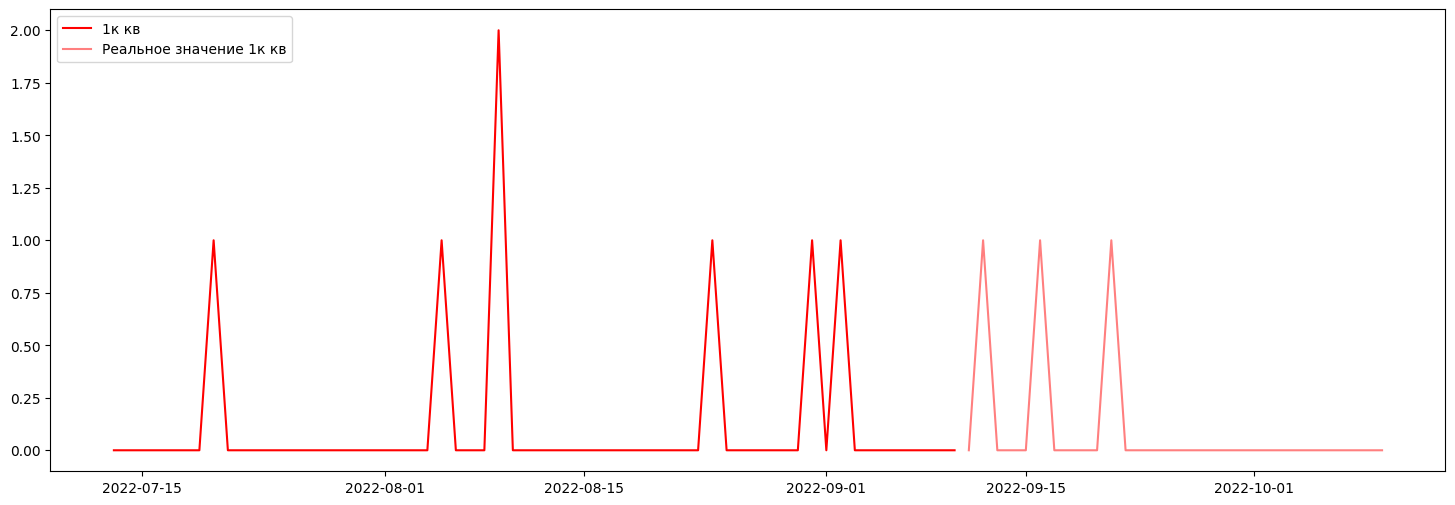

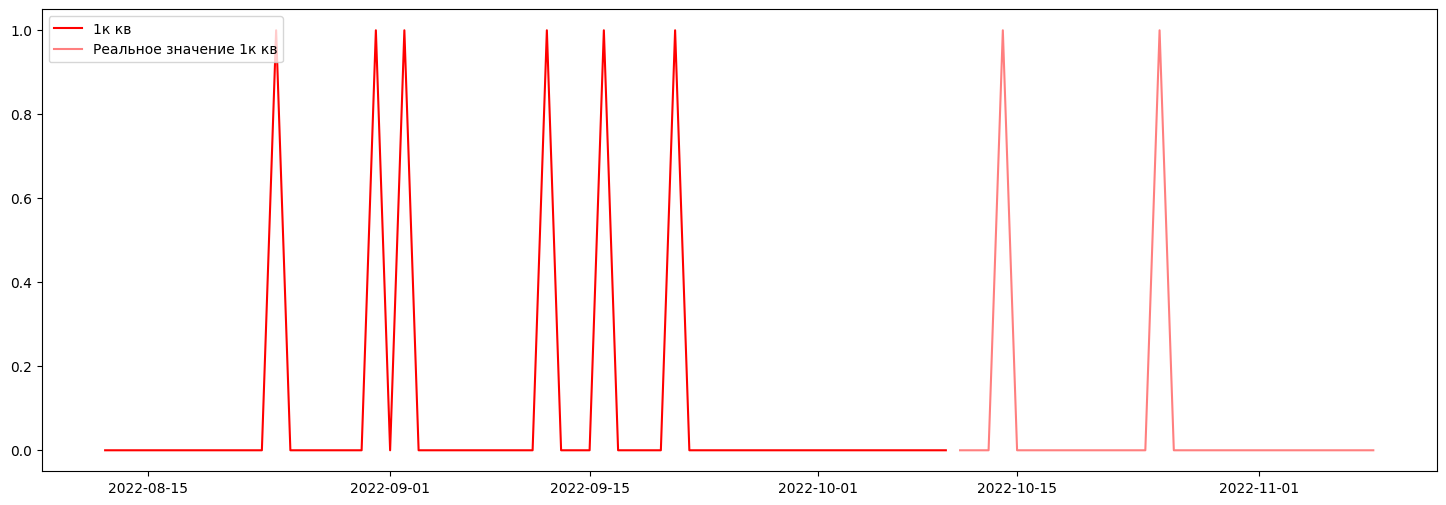

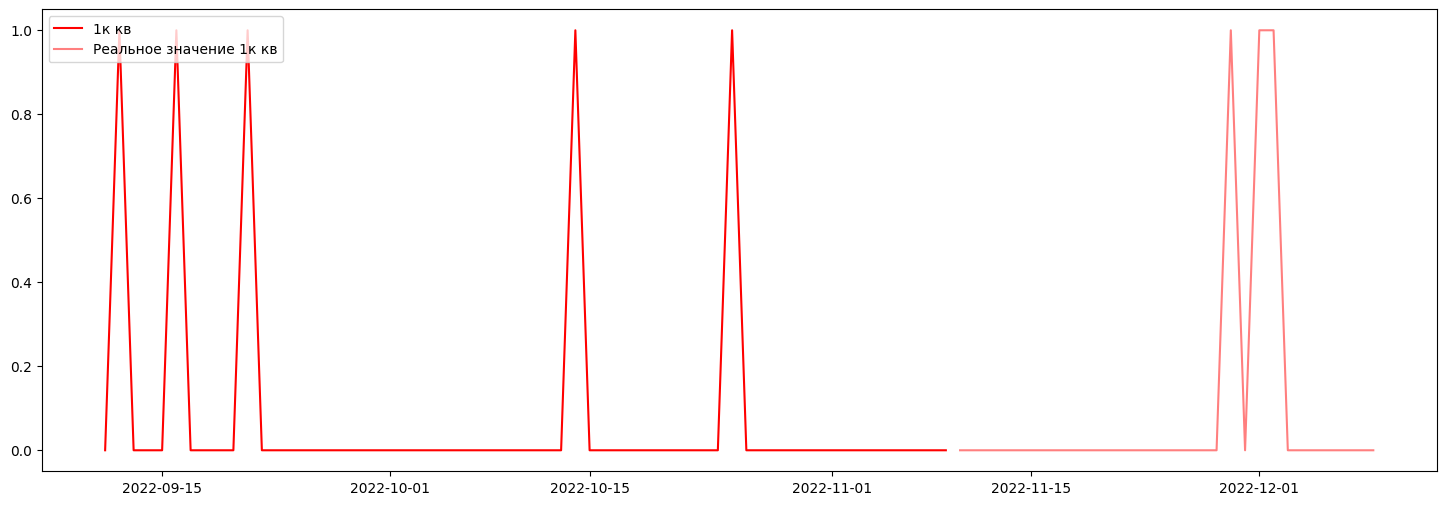

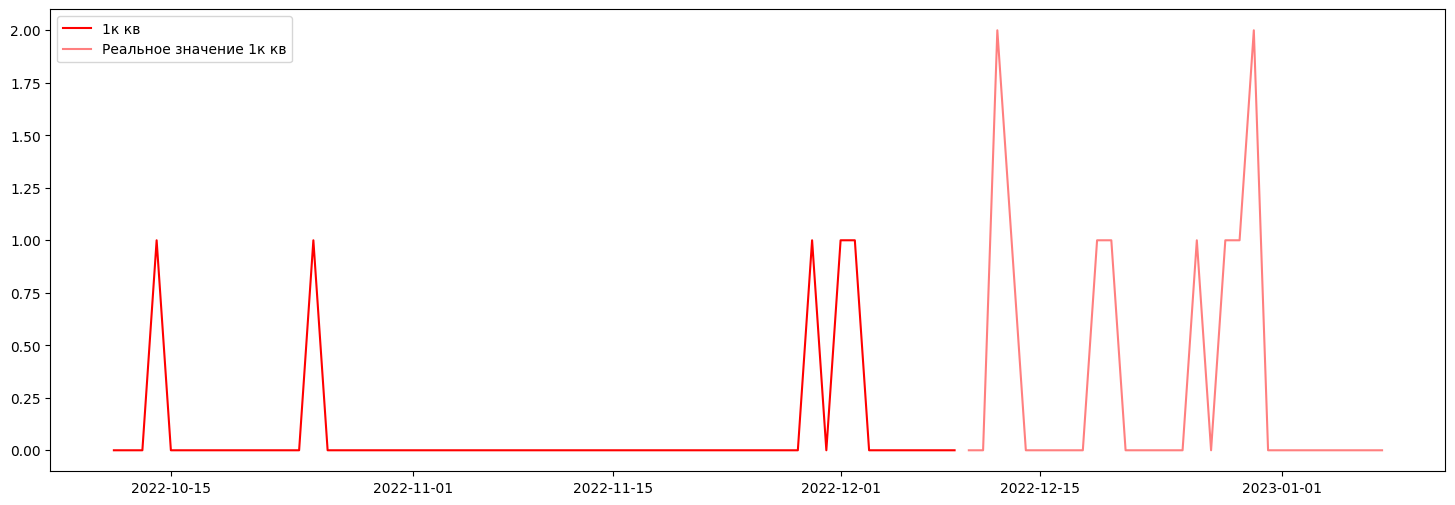

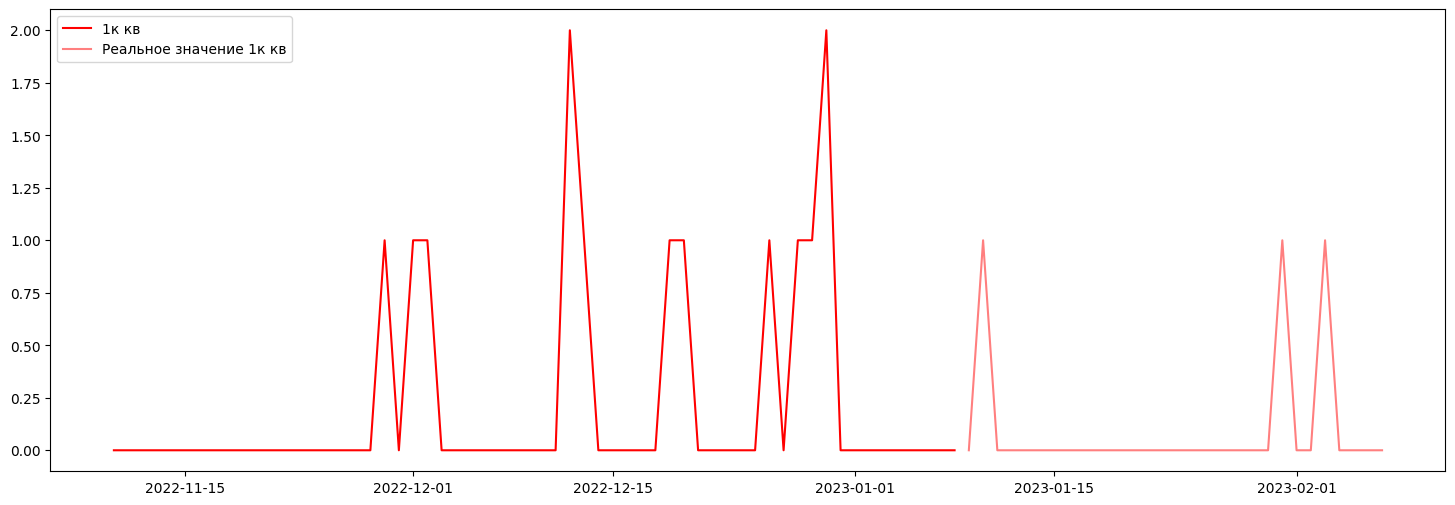

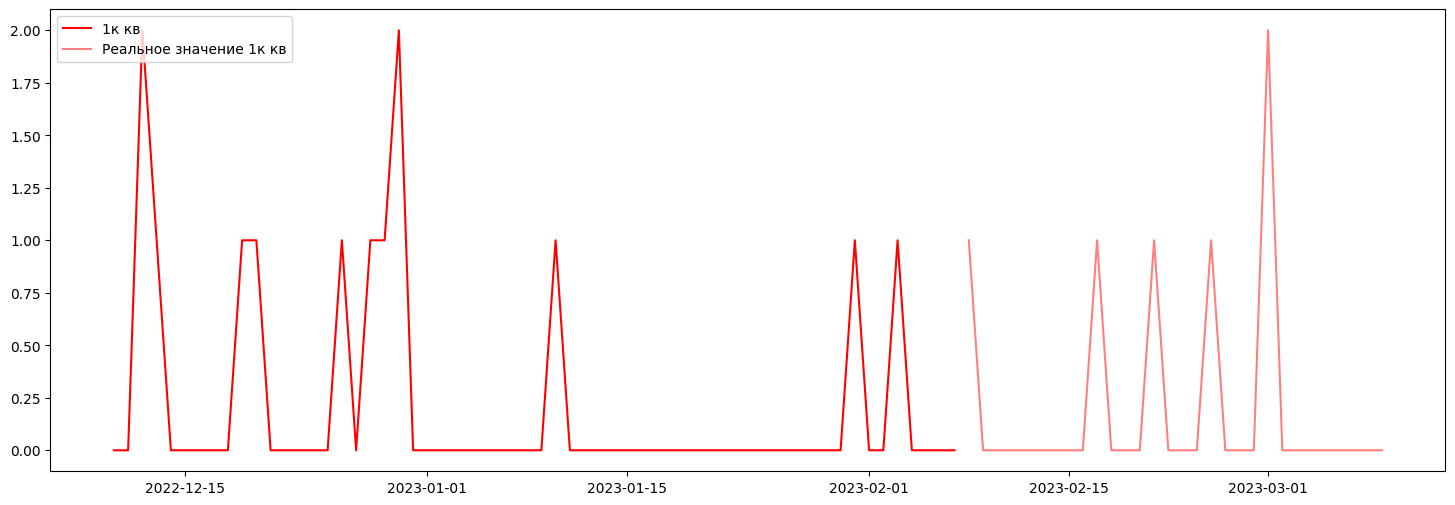

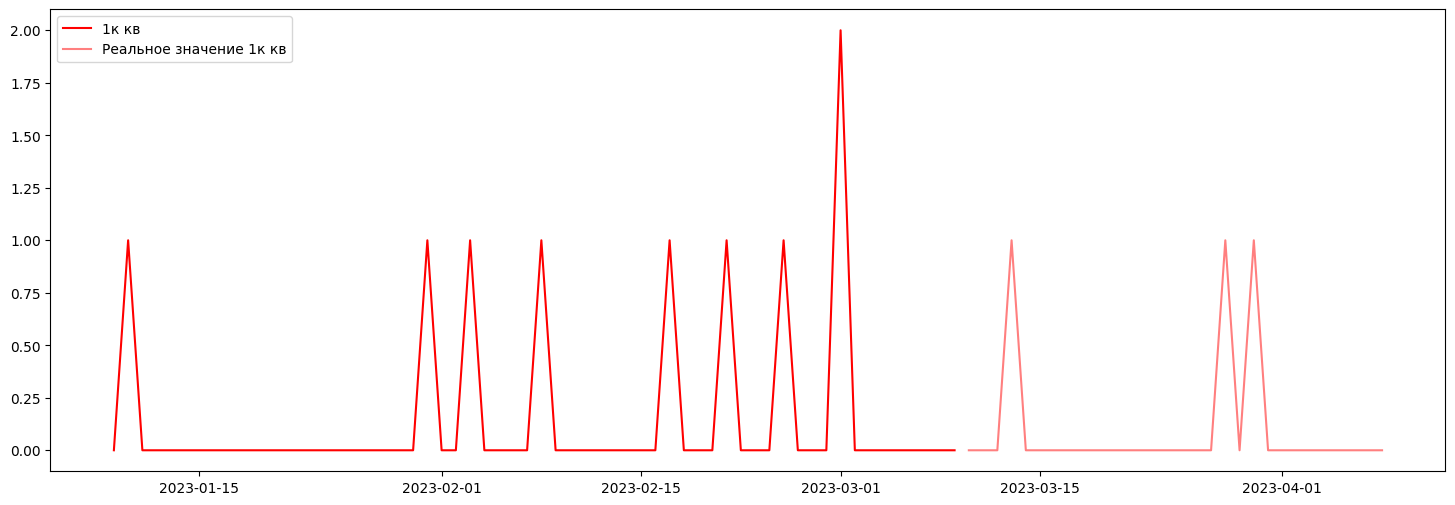

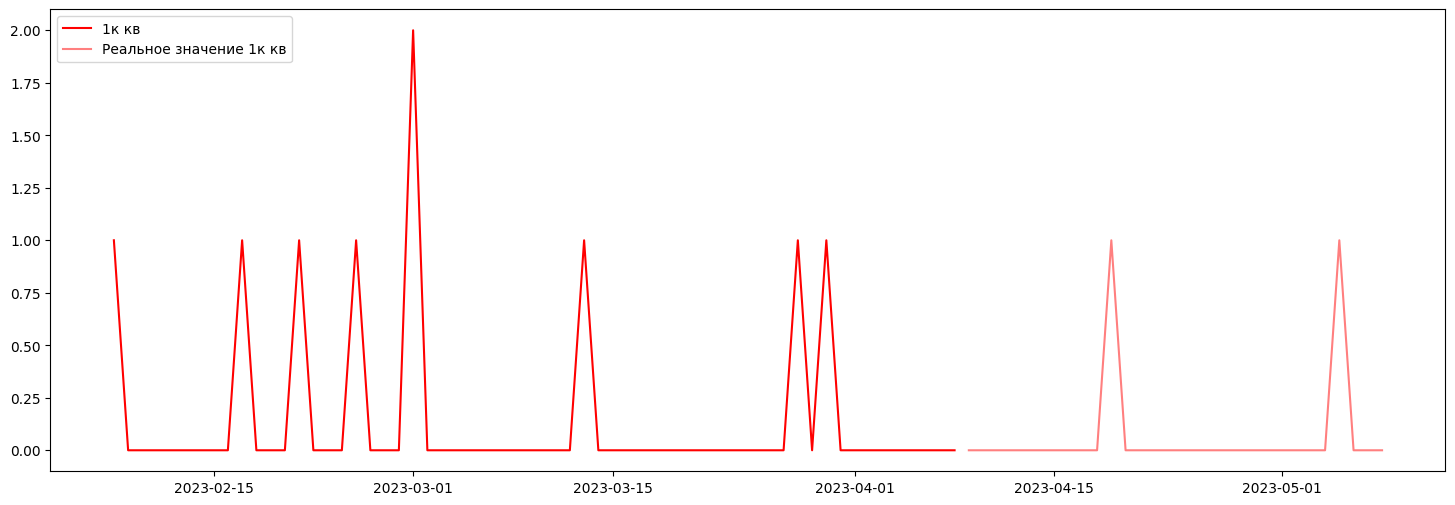

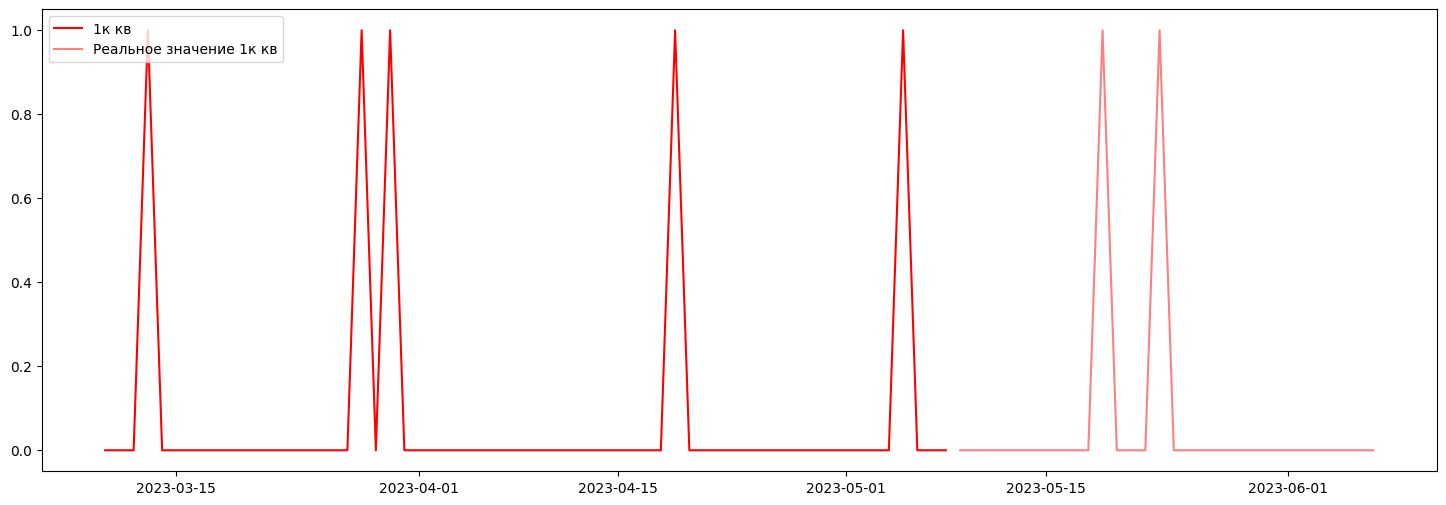

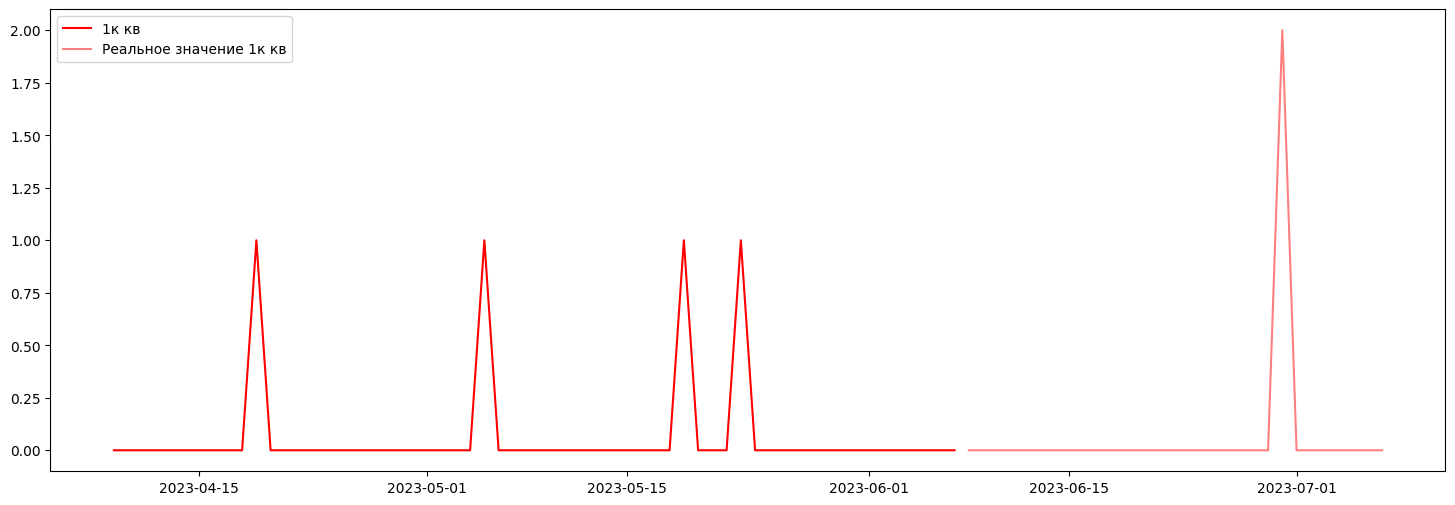

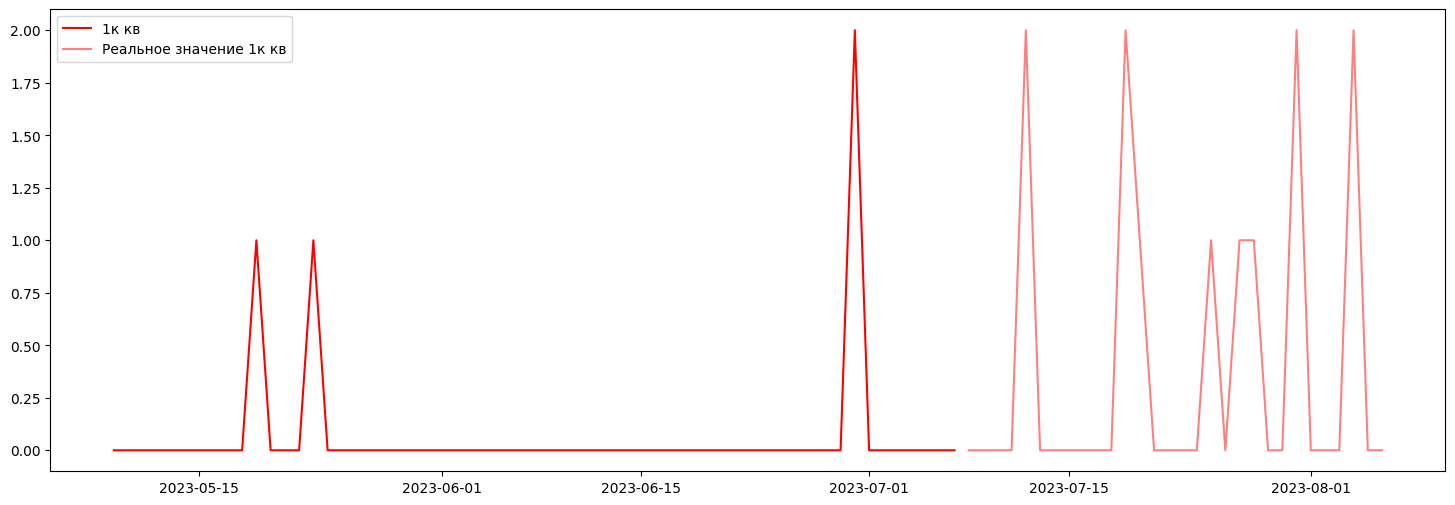

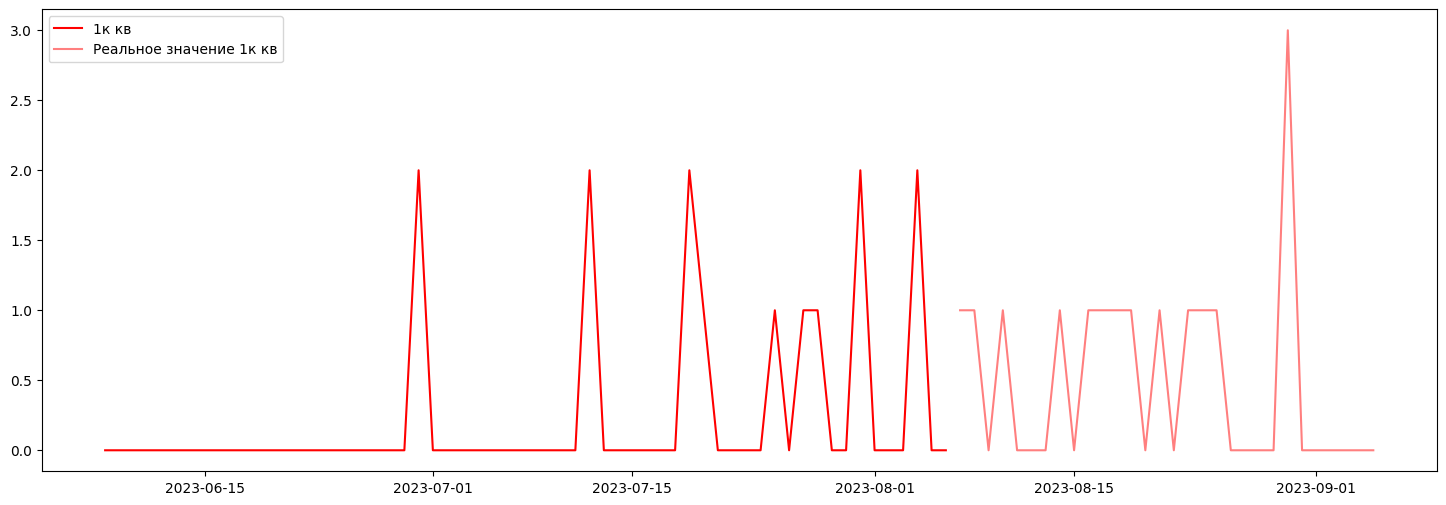

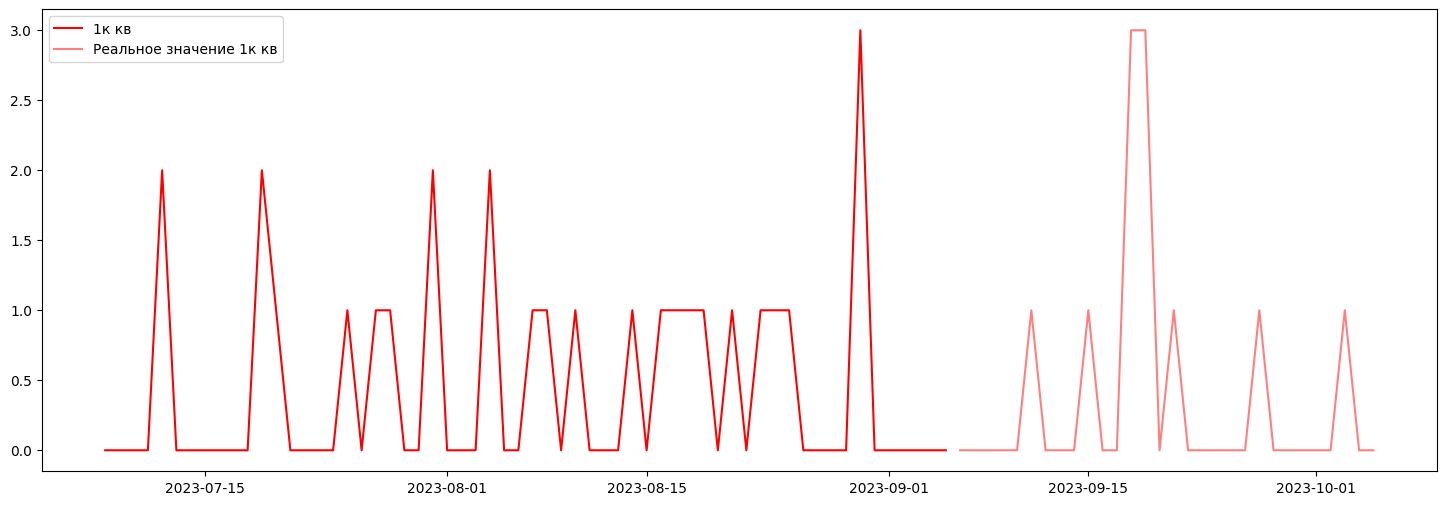

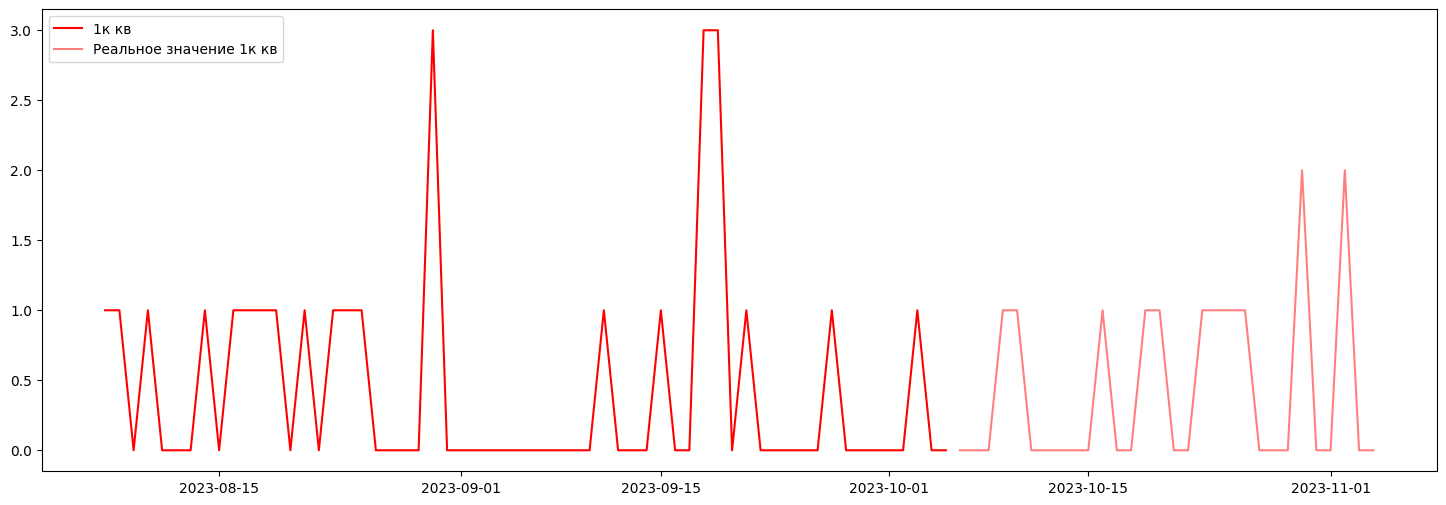

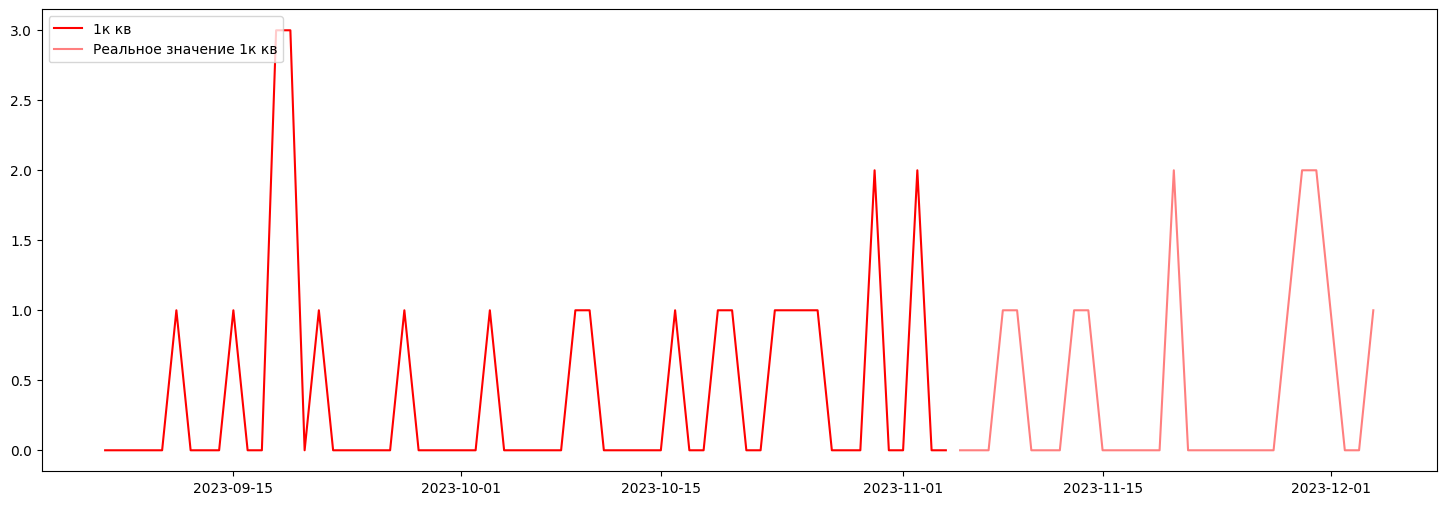

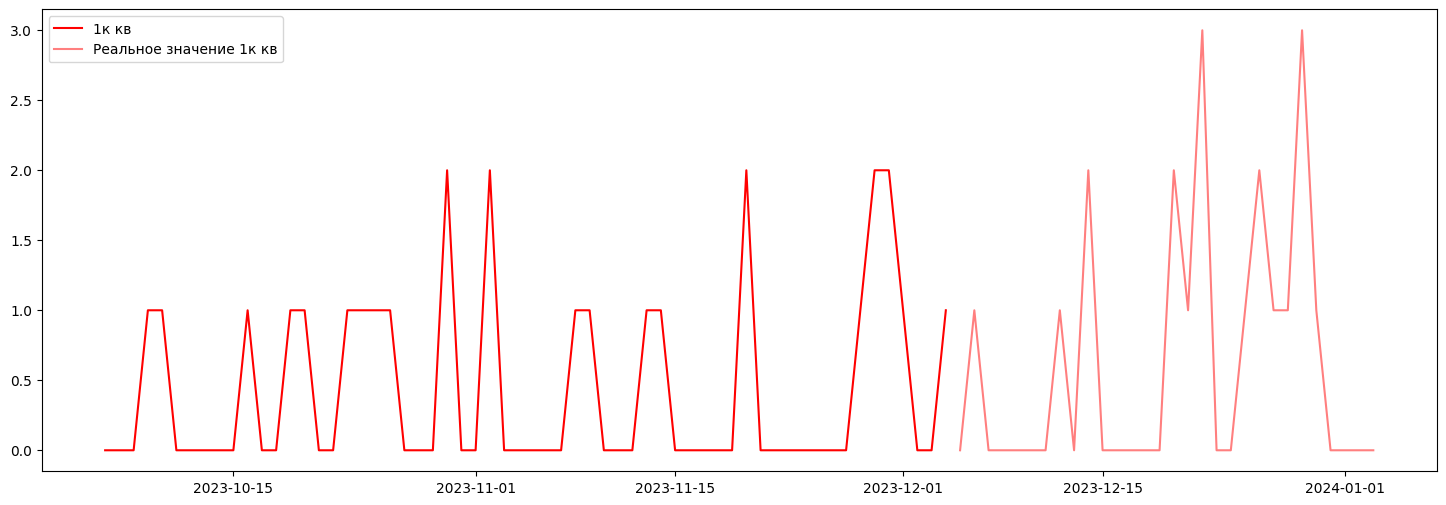

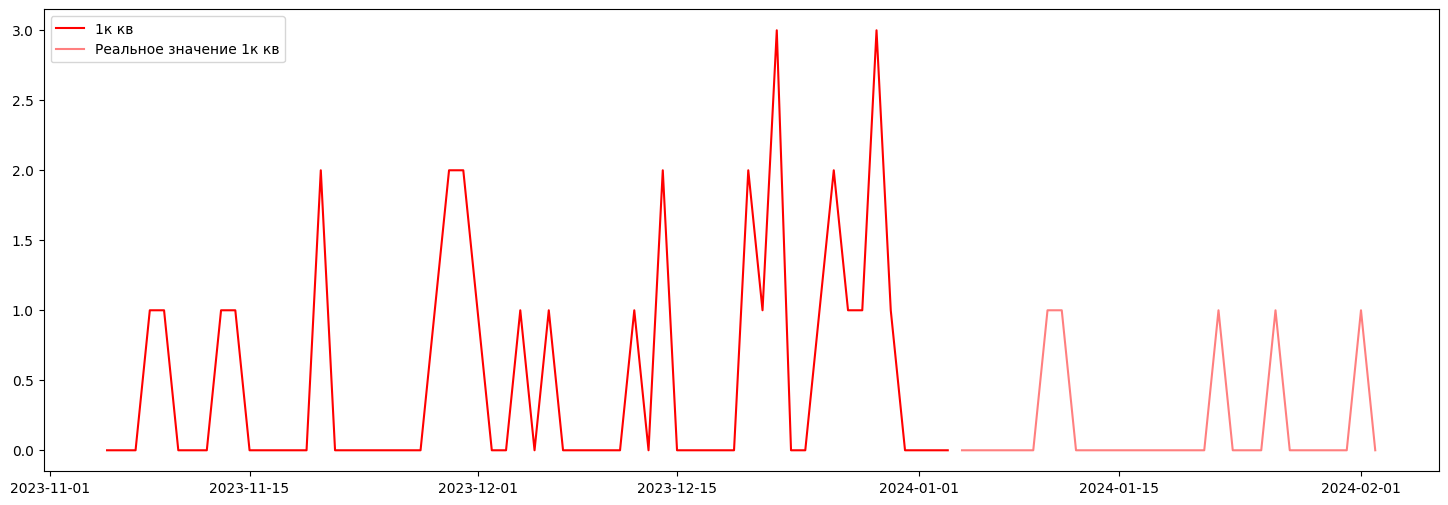

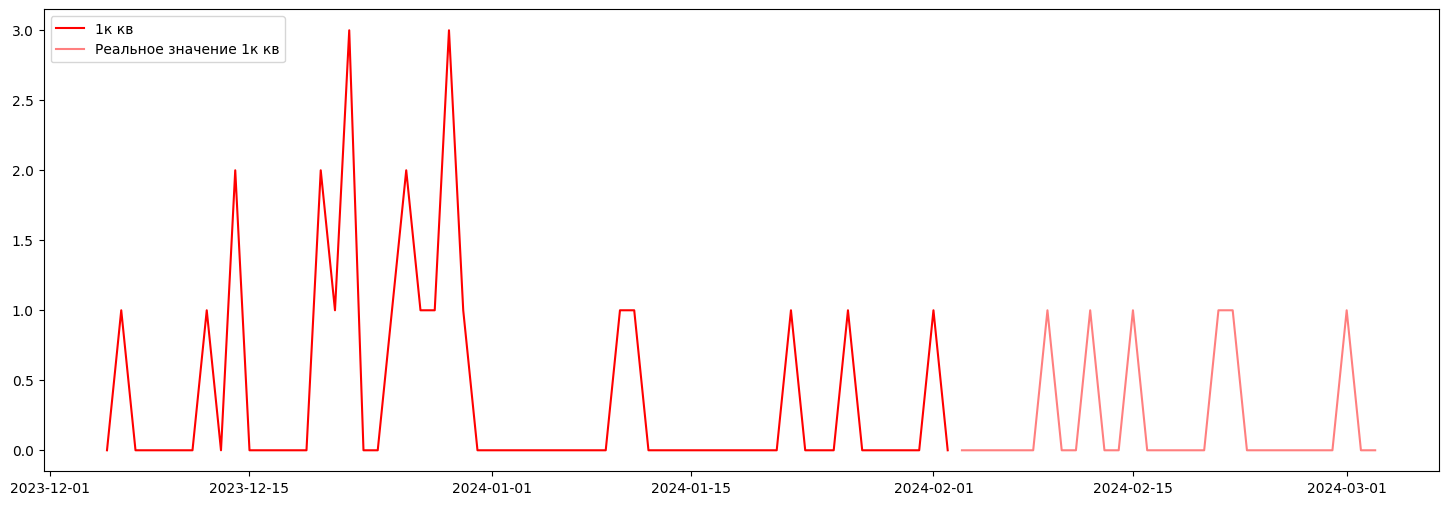

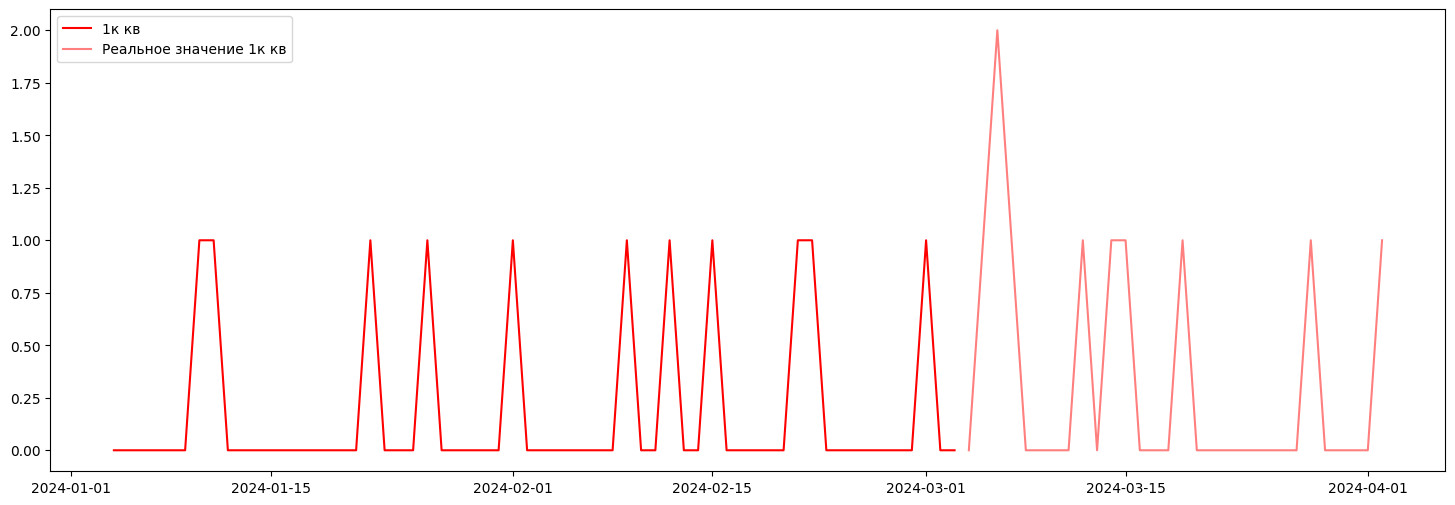

In [11]:
for i in range(0,x_val_multi_scaled.shape[0] - 1,30):
    multi_step_output_plot(x_val_multi_scaled[i].reshape(60,28),  y_val_multi_scaled[i].reshape(30,3),  np.array([]), val_dates[i] )

In [12]:
def cal_steps(num_images, batch_size):
   # calculates steps for generator
   steps = num_images // batch_size
   
   # adds 1 to the generator steps if the steps multiplied by
   # the batch size is less than the total training samples
   return steps + 1 if (steps * batch_size) < num_images else steps

In [47]:
import keras.backend as K
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization
from tensorflow.keras.activations import relu
from keras.optimizers import Adam

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

multi_step_model = tf.keras.models.Sequential()

multi_step_model.add(tf.keras.layers.LSTM(512, return_sequences=True, input_shape=(60,28)))
multi_step_model.add(keras.layers.LeakyReLU())
multi_step_model.add(Dropout(0.2))
multi_step_model.add(tf.keras.layers.LSTM(512, return_sequences=True))
multi_step_model.add(keras.layers.LeakyReLU())
multi_step_model.add(Dropout(0.2))
multi_step_model.add(tf.keras.layers.LSTM(512, return_sequences=True))
multi_step_model.add(keras.layers.LeakyReLU())
multi_step_model.add(Dropout(0.1))
multi_step_model.add(tf.keras.layers.LSTM(200))
multi_step_model.add(keras.layers.LeakyReLU())
multi_step_model.add(Dense(90, activation='relu'))
multi_step_model.add(Reshape((30, 3)))
multi_step_model.compile(loss='mse', optimizer=Adam(learning_rate=0.002), metrics=[rmse])
multi_step_model.fit(train_data_multi, epochs=500, 
                     validation_data = (val_data_multi), 
                     steps_per_epoch=30, 
                     validation_steps=30)



Epoch 1/500
30/30 [==============================] - 18s 445ms/step - loss: 0.0071 - rmse: 0.0841 - val_loss: 0.0055 - val_rmse: 0.0663
Epoch 2/500
30/30 [==============================] - 12s 412ms/step - loss: 0.0065 - rmse: 0.0806 - val_loss: 0.0063 - val_rmse: 0.0695
Epoch 3/500
30/30 [==============================] - 12s 411ms/step - loss: 0.0064 - rmse: 0.0800 - val_loss: 0.0054 - val_rmse: 0.0654
Epoch 4/500
30/30 [==============================] - 12s 411ms/step - loss: 0.0062 - rmse: 0.0788 - val_loss: 0.0057 - val_rmse: 0.0659
Epoch 5/500
30/30 [==============================] - 13s 419ms/step - loss: 0.0060 - rmse: 0.0777 - val_loss: 0.0051 - val_rmse: 0.0632
Epoch 6/500
30/30 [==============================] - 13s 437ms/step - loss: 0.0060 - rmse: 0.0773 - val_loss: 0.0051 - val_rmse: 0.0637
Epoch 7/500
30/30 [==============================] - 12s 414ms/step - loss: 0.0059 - rmse: 0.0768 - val_loss: 0.0051 - val_rmse: 0.0630
Epoch 8/500
30/30 [=============================

KeyboardInterrupt: 

In [44]:
multi_step_model.fit(train_data_multi, epochs=500, 
                     validation_data = (val_data_multi), 
                     steps_per_epoch=30, 
                     validation_steps=30)


Epoch 1/500
30/30 [==============================] - 12s 410ms/step - loss: 0.0051 - rmse: 0.0715 - val_loss: 0.0051 - val_rmse: 0.0635
Epoch 2/500
30/30 [==============================] - 12s 412ms/step - loss: 0.0051 - rmse: 0.0714 - val_loss: 0.0051 - val_rmse: 0.0629
Epoch 3/500
30/30 [==============================] - 12s 412ms/step - loss: 0.0050 - rmse: 0.0711 - val_loss: 0.0052 - val_rmse: 0.0641
Epoch 4/500
 6/30 [=====>........................] - ETA: 7s - loss: 0.0050 - rmse: 0.0707

KeyboardInterrupt: 

In [78]:
#multi_step_model.save('itakisyak.h5')
from keras.models import load_model
multi_step_model = load_model('itakisyak.h5')

ValueError: Unknown metric function: rmse. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [378]:
normalized_df[-90:-30]

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2024-02-01,0.076923,0.000000,0.00,1.0,0.4,0.8,0.208758,0.030263,1.0,0.0,...,0.000000,0.003817,0.000000,0.746032,0.535674,1.0,0.0,0.0,0.0,0.0
2024-02-02,0.000000,0.000000,0.04,1.0,0.4,0.8,0.208758,0.030263,1.0,0.0,...,0.000000,0.000000,0.000000,0.746032,0.540822,1.0,0.0,0.0,0.0,0.0
2024-02-03,0.000000,0.000000,0.00,1.0,0.4,0.8,0.208758,0.030263,1.0,0.0,...,0.000000,0.000000,0.021739,0.746032,0.539423,1.0,0.0,0.0,0.0,1.0
2024-02-04,0.000000,0.000000,0.00,1.0,0.4,0.8,0.208758,0.030263,1.0,0.0,...,0.001972,0.003817,0.021739,0.746032,0.538023,1.0,0.0,0.0,0.0,1.0
2024-02-05,0.000000,0.111111,0.00,1.0,0.4,0.8,0.208758,0.030263,1.0,0.0,...,0.005917,0.003817,0.065217,0.746032,0.536624,1.0,0.0,0.0,0.0,0.0
2024-02-06,0.000000,0.000000,0.00,1.0,0.4,0.8,0.208758,0.030263,1.0,0.0,...,0.000000,0.000000,0.000000,0.746032,0.542325,1.0,0.0,0.0,0.0,0.0
2024-02-07,0.000000,0.111111,0.08,1.0,0.4,0.8,0.208758,0.030263,1.0,0.0,...,0.000000,0.000000,0.000000,0.746032,0.542745,1.0,0.0,0.0,0.0,0.0
2024-02-08,0.000000,0.000000,0.00,1.0,0.4,0.8,0.208758,0.030263,1.0,0.0,...,0.001972,0.003817,0.000000,0.746032,0.539054,1.0,0.0,0.0,0.0,0.0
2024-02-09,0.076923,0.111111,0.04,1.0,0.4,0.8,0.207619,0.028947,1.0,0.0,...,0.003945,0.015267,0.043478,0.746032,0.539496,1.0,0.0,0.0,0.0,0.0


1/1 [==============================] - 0s 60ms/step
true 9.0  pred 5.0


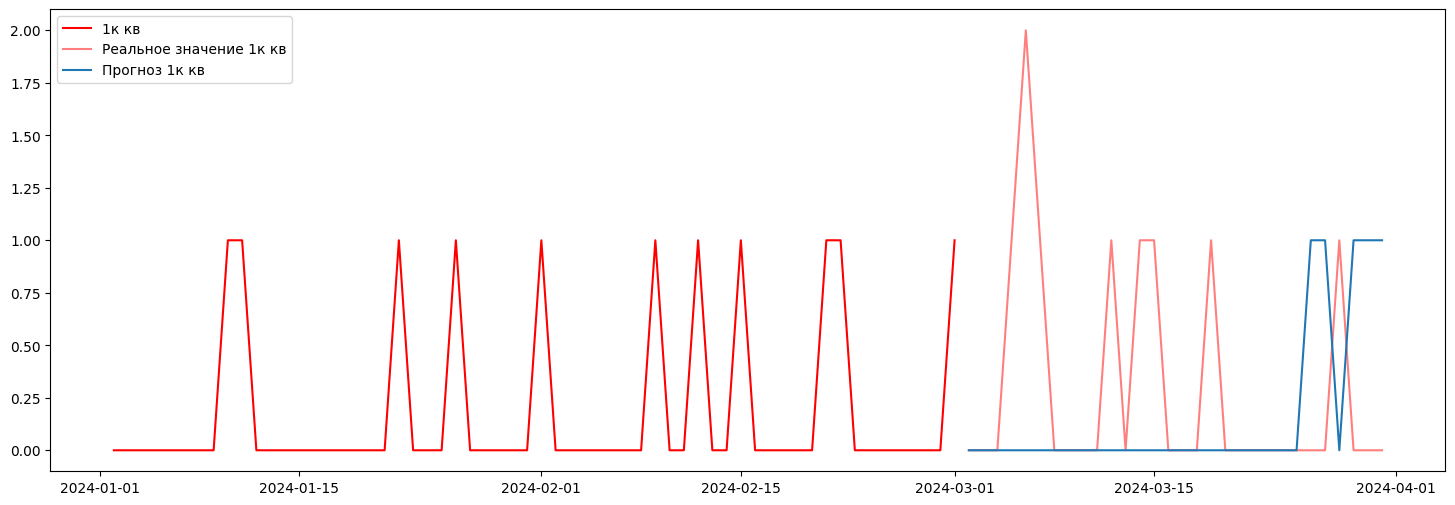

In [79]:
multi_step_output_plot(x_val_multi_scaled[-30].reshape(60,28),  y_val_multi_scaled[-30].reshape(30,3),  multi_step_model.predict(np.array(x_val_multi_scaled[-30]).reshape(1,60,28)), val_dates[-30] )

In [398]:
#multi_step_model.predict(x_val_multi_scaled[0].reshape(1,60,32)).shape

a = np.round(scalerY.inverse_transform(multi_step_model.predict(np.array(normalized_df[-90:-30]).reshape(1,60,28))[0].reshape(30,3)))

1/1 [==============================] - 0s 145ms/step


In [399]:
# Сложение столбцов
sum_columns = np.sum(a, axis=0)
sum_columns

array([ 3.,  9., 15.], dtype=float32)

1/1 [==============================] - 0s 68ms/step
true 3.0  pred 2.0


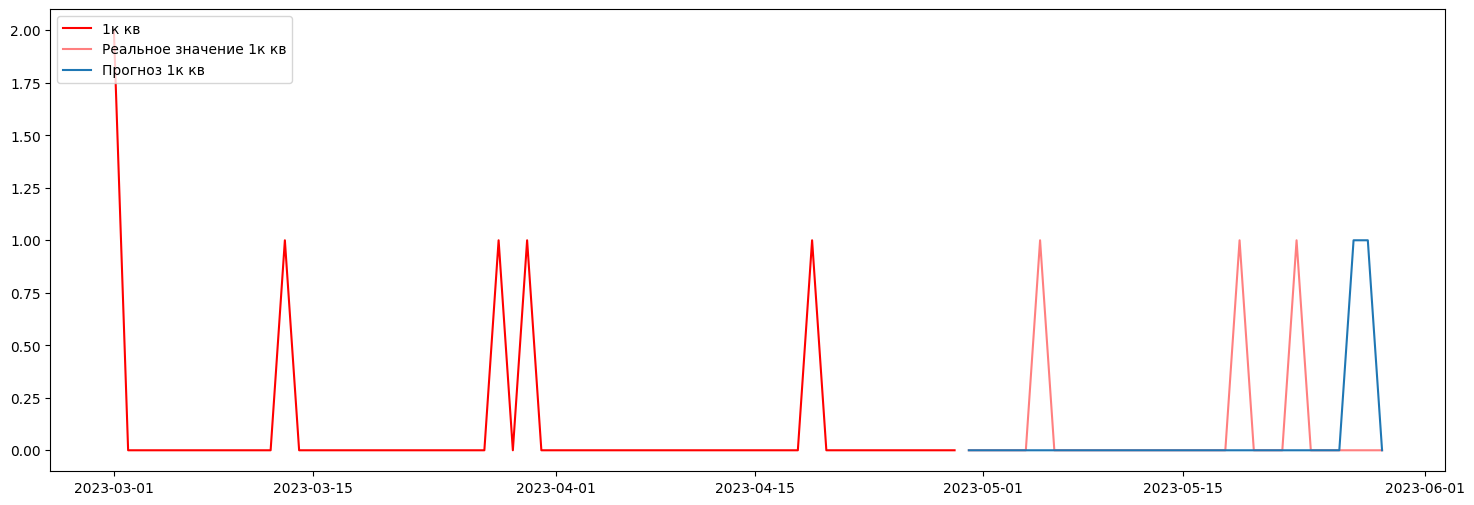

1/1 [==============================] - 0s 42ms/step
true 0.0  pred 5.0


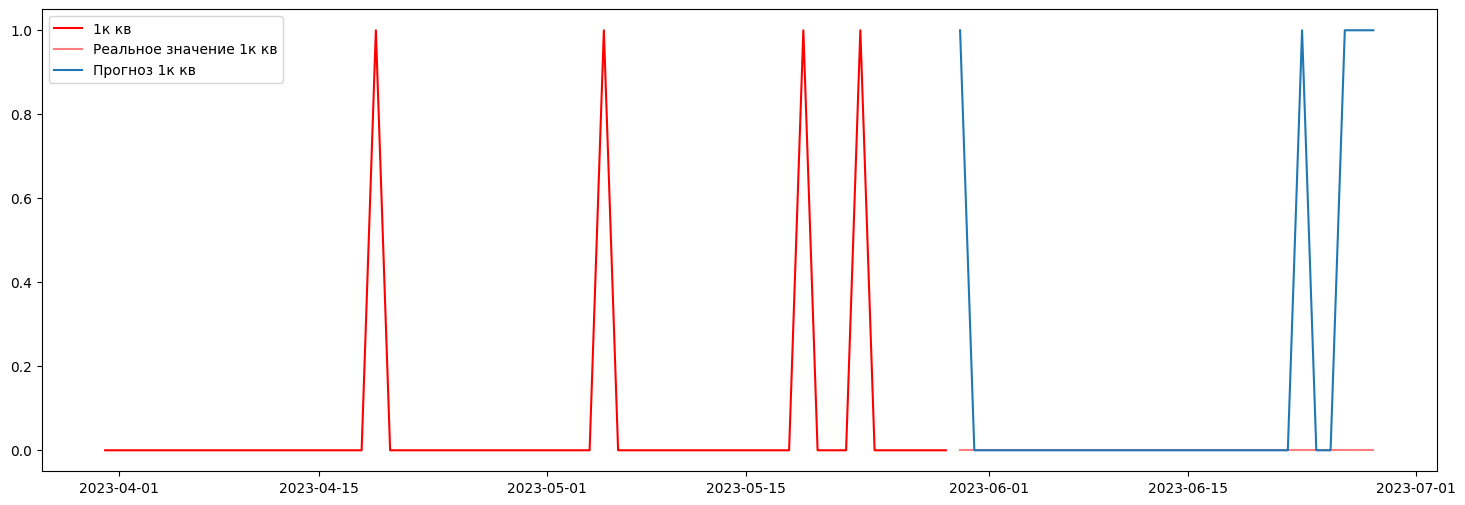

1/1 [==============================] - 0s 46ms/step
true 10.0  pred 10.0


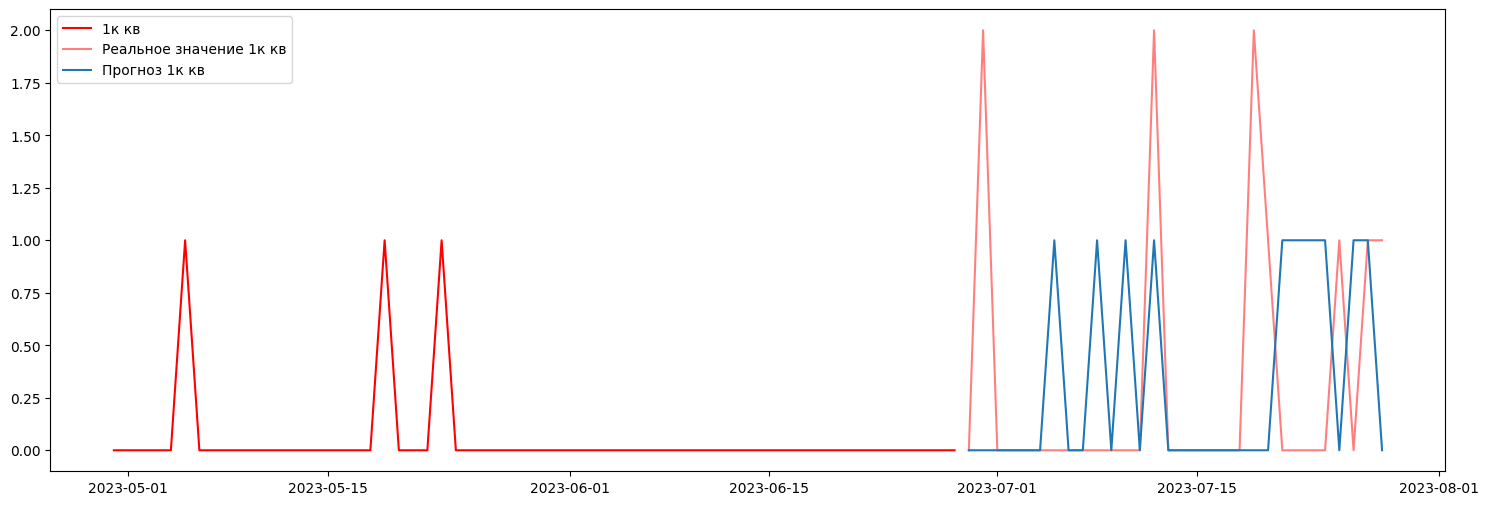

1/1 [==============================] - 0s 33ms/step
true 16.0  pred 14.0


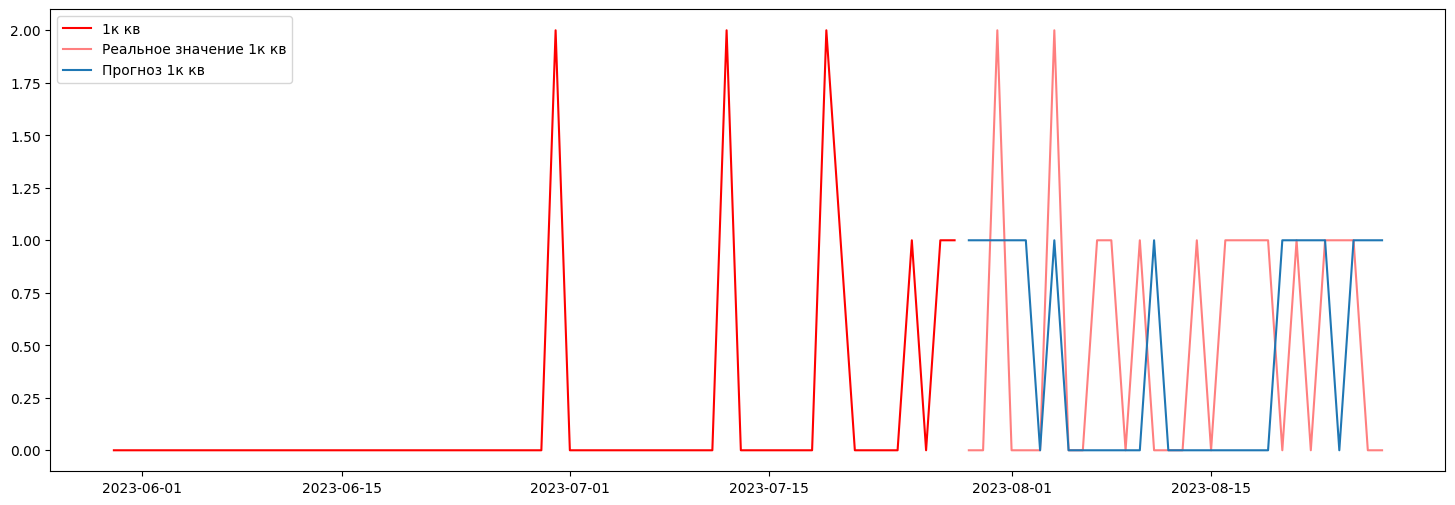

1/1 [==============================] - 0s 30ms/step
true 12.0  pred 13.0


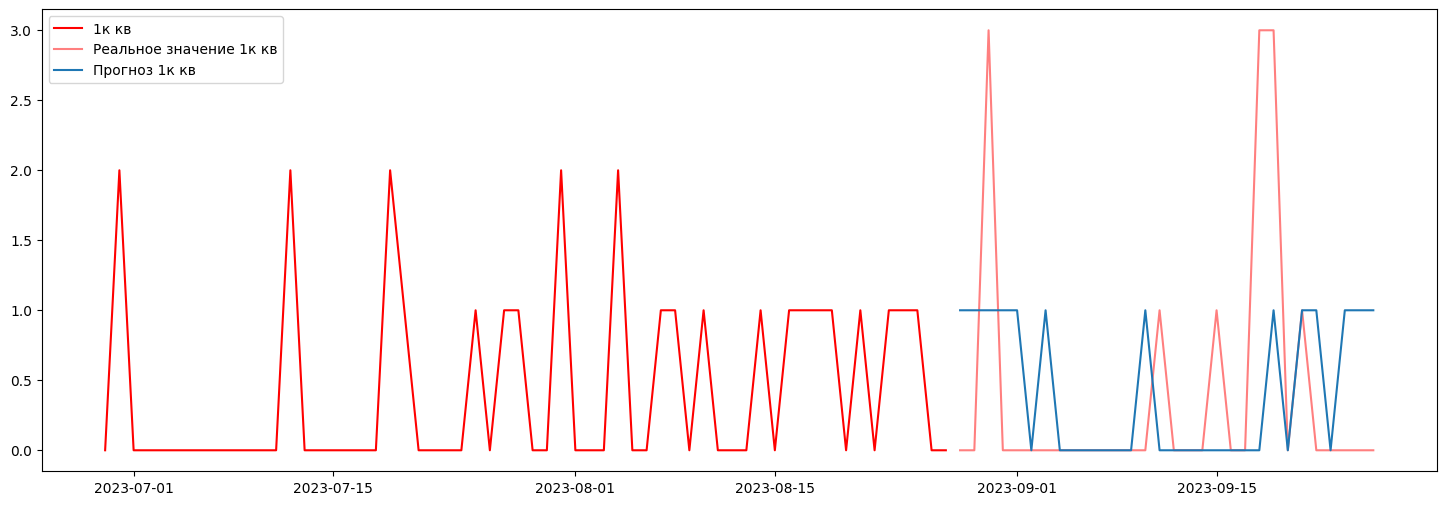

1/1 [==============================] - 0s 38ms/step
true 11.0  pred 29.0


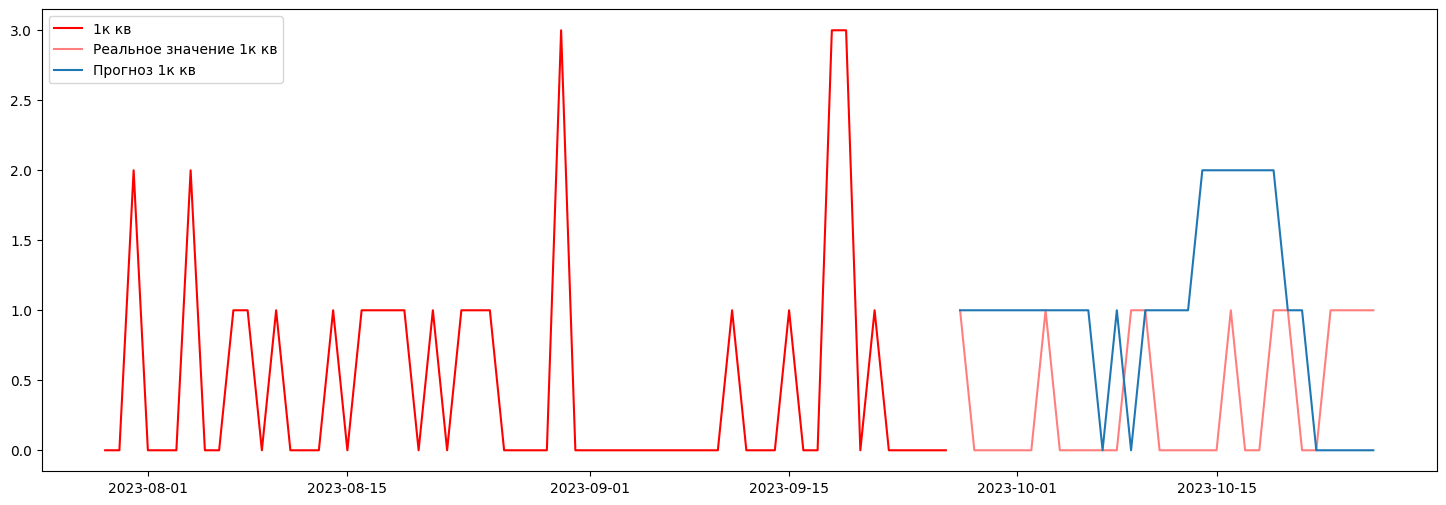

1/1 [==============================] - 0s 34ms/step
true 10.0  pred 15.0


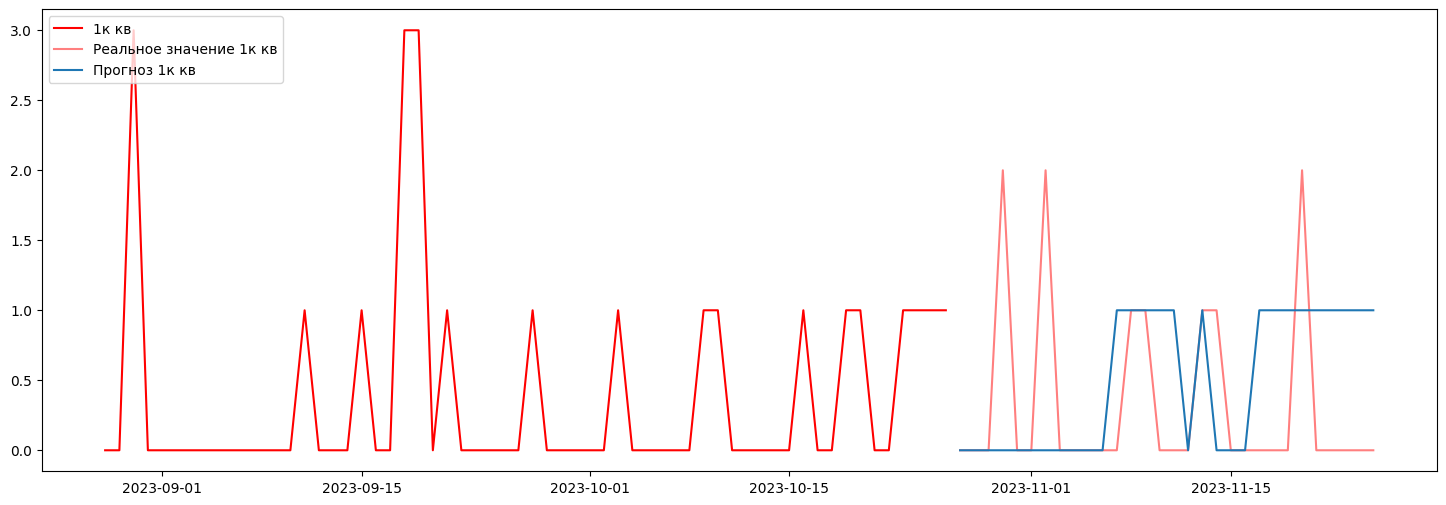

1/1 [==============================] - 0s 31ms/step
true 18.0  pred 16.0


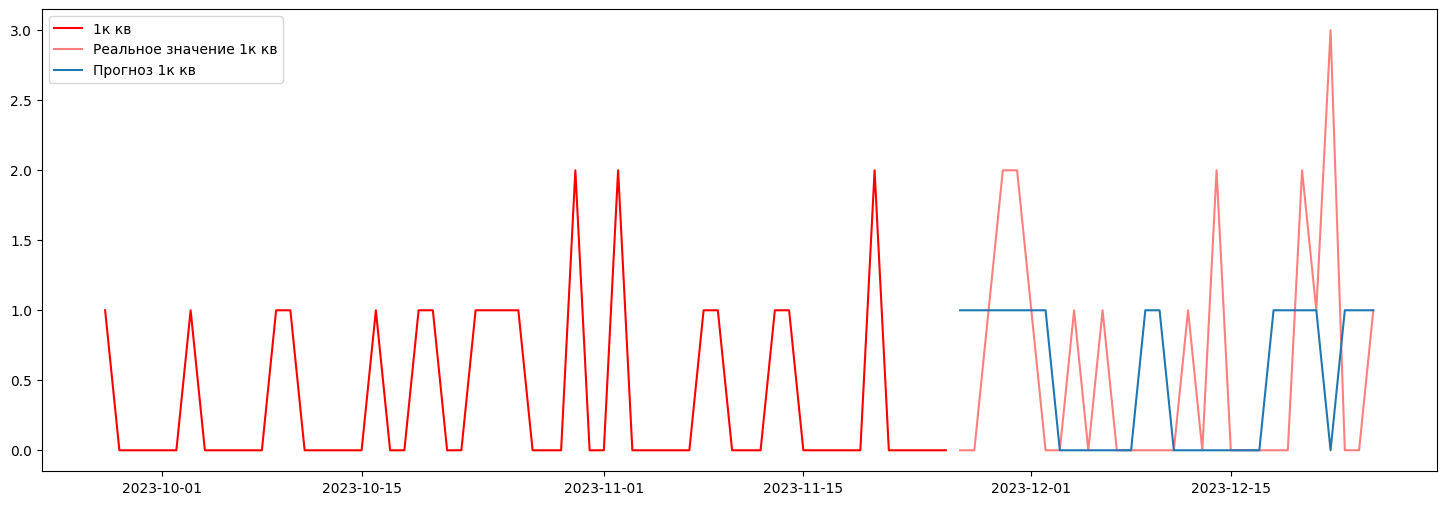

1/1 [==============================] - 0s 29ms/step
true 11.0  pred 10.0


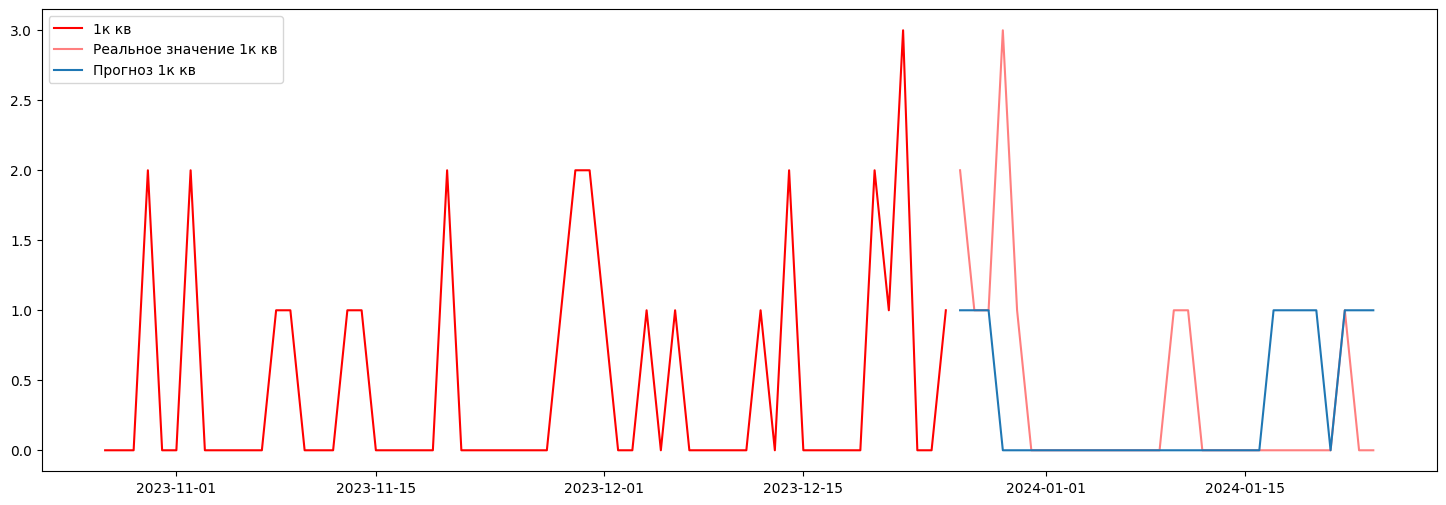

1/1 [==============================] - 0s 31ms/step
true 7.0  pred 4.0


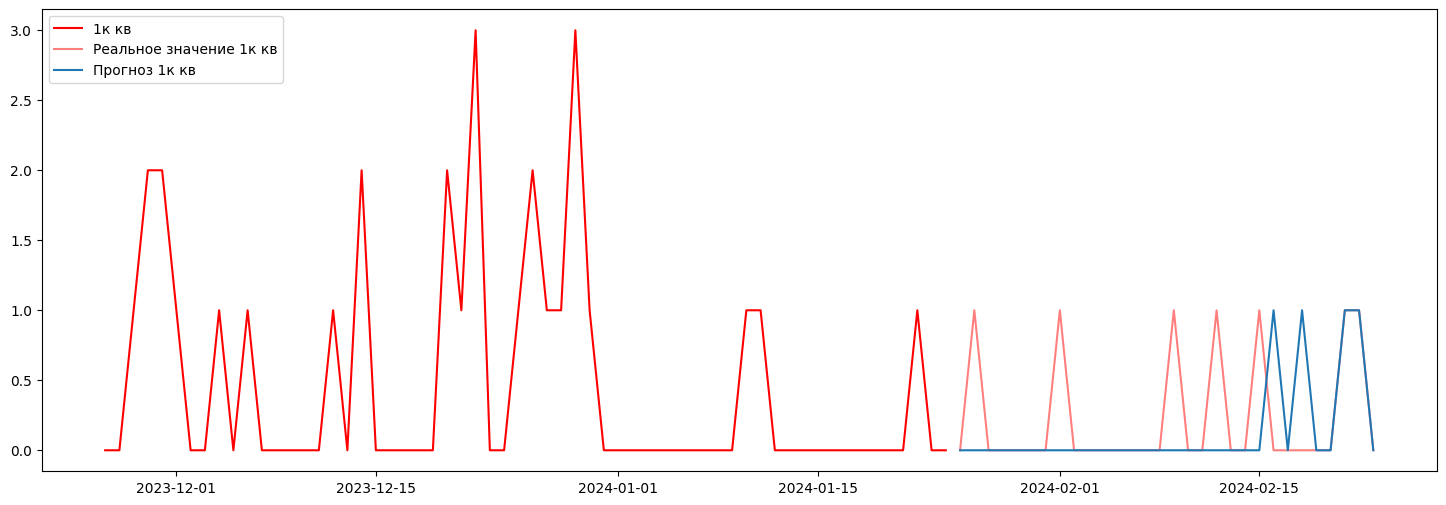

1/1 [==============================] - 0s 42ms/step
true 9.0  pred 2.0


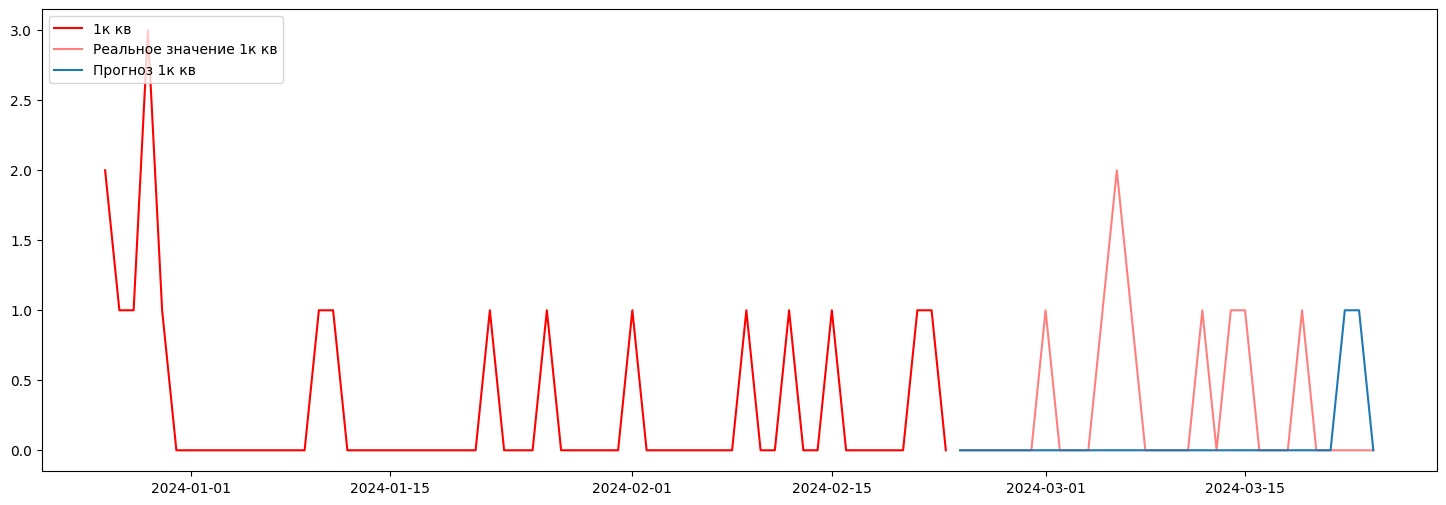

1/1 [==============================] - 0s 42ms/step
true 4.0  pred 5.0


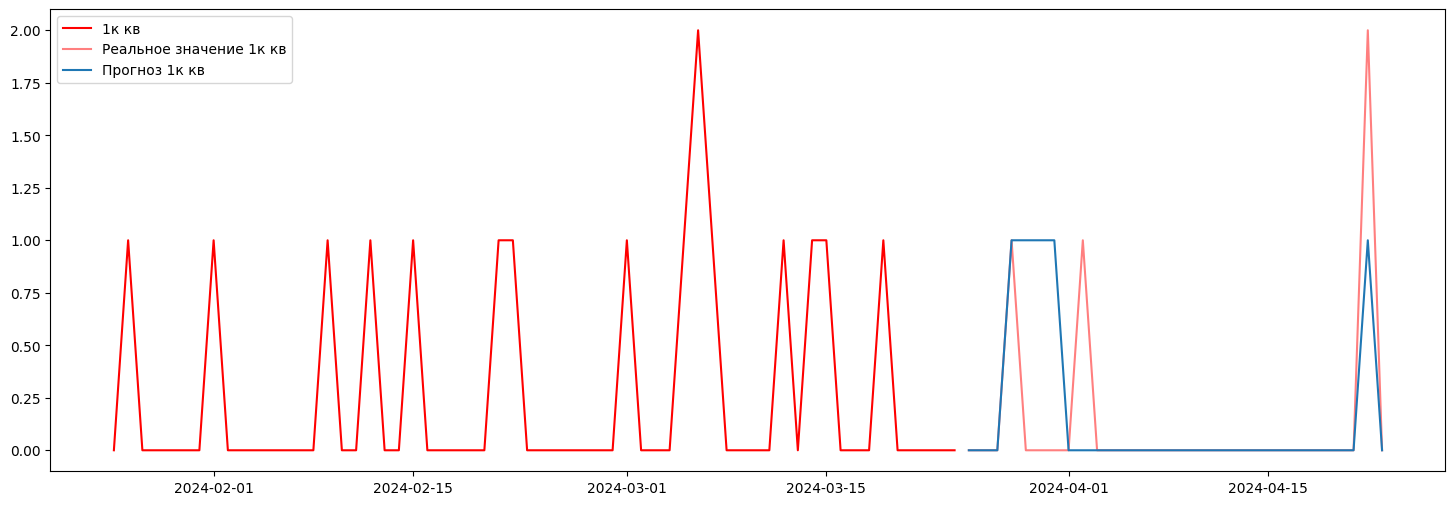

In [194]:
for i in range(30*23+21,x_val_multi_scaled.shape[0] - 1,30):
    multi_step_output_plot(x_val_multi_scaled[i].reshape(60,28),  y_val_multi_scaled[i].reshape(30,3),  multi_step_model.predict(np.array(x_val_multi_scaled[i]).reshape(1,60,28)), val_dates[i] )

In [ ]:
normalized_df[x_train_multi_scaled.shape[0]:][60:90].shape

In [405]:
df.loc['2024-04-01':'2024-04-30']['CountContracts'].sum()

8.0

In [78]:
np.array(normalized_df[-60:]).shape

(60, 28)

In [100]:
multi_step_model.predict(np.array(normalized_df[-60:]).reshape(1,60,16))

1/1 [==============================] - 1s 904ms/step


array([[0.02624278, 0.02116373, 0.0213635 , 0.03152691, 0.01427915,
        0.03061843, 0.01187319, 0.00963882, 0.02471922, 0.02772876,
        0.02665581, 0.02165598, 0.02968992, 0.02751821, 0.02802832,
        0.02840546, 0.01565018, 0.01506225, 0.0282336 , 0.02611518,
        0.02350223, 0.02907352, 0.03352031, 0.02554901, 0.        ,
        0.02446536, 0.03882216, 0.01928746, 0.02951174, 0.04336772]],
      dtype=float32)

In [345]:
predicted_value = scalerY.inverse_transform(multi_step_model.predict(np.array(normalized_df[-60:]).reshape(1,60,16))[0].reshape(1,30))

ValueError: cannot reshape array of size 1920 into shape (1,60,16)

In [102]:
np.round(predicted_value)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]],
      dtype=float32)

In [103]:
np.round(predicted_value).sum()

2.0

# test.loc['2024-04-01':'2024-04-30']['smoothed_CountContracts'].sum()

In [209]:
test['smoothed_CountContracts'].sum()

26.0

In [210]:
df.loc['2024-03-01':'2024-03-31']['smoothed_CountContracts'].sum()

24.0

In [303]:
test

,smoothed_CountContracts,ActiveCount,WebReklama,SiteReklama,OuterReklama,TVReklama,PaperReklama,OtherReklama,tisa_Floormax,tisa_Flooravg,...,kr,AverageCostContractUSD,target_last_year,target_last_month,RoomRemain,is_winter,is_spring,is_summer,is_fall,is_weekend
datec,,,,,,,,,,,,,,,,,,,,,
2024-04-01,0.0,8.0,2.0,0.0,0.0,0.0,0.0,11.0,25.0,11.0,...,16.0,2519.206299,0.0,1.0,333.0,0,1,0,0,0
2024-04-02,1.0,5.0,1.0,0.0,0.0,0.0,0.0,15.0,25.0,11.0,...,16.0,2506.725830,0.0,0.0,332.0,0,1,0,0,0
2024-04-03,0.0,22.0,2.0,0.0,0.0,0.0,0.0,31.0,25.0,11.0,...,16.0,2514.126221,1.0,0.0,332.0,0,1,0,0,0
2024-04-04,2.0,19.0,0.0,0.0,0.0,0.0,0.0,27.0,25.0,11.0,...,16.0,2516.156494,0.0,2.0,330.0,0,1,0,0,0
2024-04-05,0.0,21.0,0.0,2.0,0.0,0.0,0.0,28.0,25.0,11.0,...,16.0,2509.083984,1.0,2.0,330.0,0,1,0,0,0
2024-04-06,0.0,9.0,1.0,3.0,0.0,0.0,0.0,10.0,25.0,11.0,...,16.0,2507.276855,2.0,2.0,330.0,0,1,0,0,0
2024-04-07,0.0,4.0,2.0,3.0,0.0,0.0,0.0,3.0,25.0,11.0,...,16.0,2505.472412,0.0,0.0,330.0,0,1,0,0,0
2024-04-08,1.0,16.0,0.0,0.0,1.0,0.0,0.0,22.0,25.0,11.0,...,16.0,2503.851318,0.0,1.0,329.0,0,1,0,0,0
2024-04-09,0.0,15.0,1.0,0.0,0.0,0.0,0.0,18.0,25.0,11.0,...,16.0,2495.774414,0.0,0.0,329.0,0,1,0,0,0


In [307]:
multi_step_model.save('C:/Users/LEONSAM/Downloads/path_to_my_model.h5')

In [314]:
pip install tf2onnx

   ---------------------------------------- 0.0/455.8 kB ? eta -:--:--
    --------------------------------------- 10.2/455.8 kB ? eta -:--:--
   -- ------------------------------------ 30.7/455.8 kB 325.1 kB/s eta 0:00:02
   ----- --------------------------------- 61.4/455.8 kB 465.5 kB/s eta 0:00:01
   ------------ ------------------------- 153.6/455.8 kB 833.5 kB/s eta 0:00:01
   ------------------------- -------------- 286.7/455.8 kB 1.3 MB/s eta 0:00:01
   ----------------------------------- ---- 399.4/455.8 kB 1.5 MB/s eta 0:00:01
   ---------------------------------------- 455.8/455.8 kB 1.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [315]:
import tensorflow as tf
import tf2onnx
import onnx
from tensorflow import keras
from keras.models import load_model

model = load_model('C:/Users/LEONSAM/Downloads/path_to_my_model.h5')

onnx_model, _ = tf2onnx.convert.from_keras(model)
onnx.save(onnx_model, 'new_model.onnx')

In [317]:
df.columns

Index(['smoothed_CountContracts', 'ActiveCount', 'RingSource', 'AgentSource',
       'WebSource', 'WebReklama', 'SiteReklama', 'OuterReklama', 'TVReklama',
       'PaperReklama', 'OtherReklama', 'AverageSpacedesign', 'tisa_Floormin',
       'tisa_Floormax', 'tisa_Flooravg', 'tisa_QuantityMin', 'tisa_PriceMin',
       'tisa_CostMin', 'tisa_Quantitymax', 'tisa_Pricemax', 'tisa_Costmax',
       'tisa_Quantityavg', 'tisa_Priceavg', 'tisa_Costavg', 'kr',
       'AverageCostContractUSD', 'target_last_year', 'target_last_month',
       'RoomRemain', 'is_winter', 'is_spring', 'is_summer', 'is_fall',
       'is_weekend'],
      dtype='object')

In [318]:
# Загрузка модели
model = onnx.load("new_model.onnx")

# Извлечение метаданных
for i, input in enumerate(model.graph.input):
    print(f"Input {i}: {input.name}")

for i, output in enumerate(model.graph.output):
    print(f"Output {i}: {output.name}")

Input 0: input_19
Output 0: dense_18


In [334]:
df.to_csv('ds.csv', index=False)

In [15]:
df

,smoothed_CountContracts,ActiveCount,RingSource,AgentSource,WebSource,WebReklama,SiteReklama,OuterReklama,TVReklama,PaperReklama,...,kr,AverageCostContractUSD,target_last_year,target_last_month,RoomRemain,is_winter,is_spring,is_summer,is_fall,is_weekend
datec,,,,,,,,,,,,,,,,,,,,,
2014-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.5,4159.350586,0.0,0.0,53.0,1,0,0,0,0
2014-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.5,4128.563965,0.0,0.0,53.0,1,0,0,0,0
2014-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.5,4116.128418,0.0,5.0,53.0,1,0,0,0,0
2014-01-04,0.0,7.0,17.0,0.0,1.0,5.0,2.0,6.0,0.0,0.0,...,5.5,4115.715332,0.0,1.0,53.0,1,0,0,0,0
2014-01-05,0.0,10.0,19.0,0.0,0.0,5.0,5.0,3.0,0.0,0.0,...,5.5,4115.302246,0.0,0.0,53.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,1.0,14.0,3.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.0,2514.349121,0.0,0.0,360.0,1,0,0,0,0
2024-02-27,0.0,11.0,3.0,17.0,0.0,0.0,1.0,0.0,0.0,0.0,...,16.0,2523.089844,1.0,0.0,360.0,1,0,0,0,0
2024-02-28,1.0,17.0,3.0,21.0,0.0,0.0,3.0,0.0,0.0,0.0,...,16.0,2547.336914,2.0,0.0,359.0,1,0,0,0,0


In [204]:
# Создание DatetimeIndex с первым числом каждого месяца
date_index = pd.date_range(start='2013-01-01', end='2024-04-30', freq='MS')

# Преобразование DatetimeIndex в DataFrame
TMP = pd.DataFrame(date_index, columns=['date'])

TMP[-12:].values

array([['2023-05-01T00:00:00.000000000'],
       ['2023-06-01T00:00:00.000000000'],
       ['2023-07-01T00:00:00.000000000'],
       ['2023-08-01T00:00:00.000000000'],
       ['2023-09-01T00:00:00.000000000'],
       ['2023-10-01T00:00:00.000000000'],
       ['2023-11-01T00:00:00.000000000'],
       ['2023-12-01T00:00:00.000000000'],
       ['2024-01-01T00:00:00.000000000'],
       ['2024-02-01T00:00:00.000000000'],
       ['2024-03-01T00:00:00.000000000'],
       ['2024-04-01T00:00:00.000000000']], dtype='datetime64[ns]')

In [145]:
predictedCheck[5] = 29

In [85]:
np.round((np.array(predictedCheck).reshape(12,1)+(PR[-12:].values+PR[-24:-12].values)/2)/2)

array([[ 6.],
       [ 5.],
       [ 8.],
       [10.],
       [12.],
       [18.],
       [11.],
       [12.],
       [13.],
       [ 4.],
       [ 4.],
       [ 6.]], dtype=float32)

array(['2023-05-01T00:00:00.000000000', '2023-06-01T00:00:00.000000000',
       '2023-07-01T00:00:00.000000000', '2023-08-01T00:00:00.000000000',
       '2023-09-01T00:00:00.000000000', '2023-10-01T00:00:00.000000000',
       '2023-11-01T00:00:00.000000000', '2023-12-01T00:00:00.000000000',
       '2024-01-01T00:00:00.000000000', '2024-02-01T00:00:00.000000000',
       '2024-03-01T00:00:00.000000000', '2024-04-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

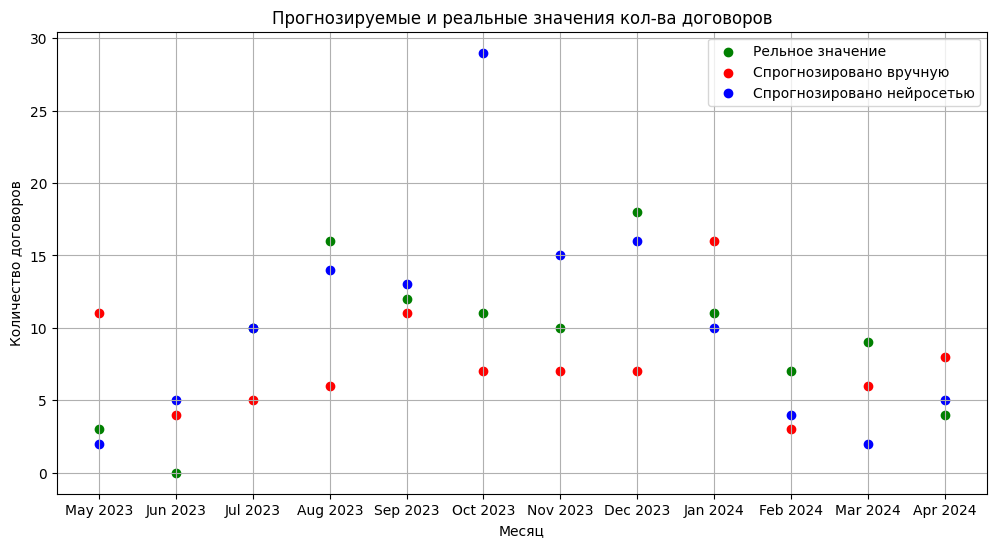

In [198]:
df_grouped = df.groupby(df.index.to_period('M')).sum()
#df.loc['2024-03-01':'2024-03-31']
TR = df_grouped[['CountContracts']][1:]
PR = df_grouped[['CountContracts']][:-1]

# Создание графика
plt.figure(figsize=(12, 6))

# Построение графиков для каждого массива с разными цветами
array = np.arange(0, len(TR[-12:].values))

AtualArray = np.array(actualCheck)
CasualPredictedArray = np.round((PR[-12:].values+PR[-24:-12].values)/2).reshape(12)
NNPredictedArray = np.round(np.array(predictedCheck).reshape(12,1)).reshape(12)

plt.scatter(TMP[-12:].values, AtualArray, marker='o', color='green', label='Рельное значение')
plt.scatter(TMP[-12:].values, CasualPredictedArray, marker='o', color='red', label='Спрогнозировано вручную')
plt.scatter(TMP[-12:].values, NNPredictedArray, marker='o', color='blue', label='Спрогнозировано нейросетью')

# Настройка графика
plt.title('Прогнозируемые и реальные значения кол-ва договоров')
plt.xlabel('Месяц')
plt.ylabel('Количество договоров')
plt.legend()
plt.grid(True)

# Отображение графика
plt.show()

In [212]:
TMP

Index(['May 2023', 'May 2023', 'May 2023', 'May 2023', 'May 2023', 'May 2023',
       'May 2023', 'May 2023', 'May 2023', 'May 2023', 'May 2023', 'May 2023'],
      dtype='object')

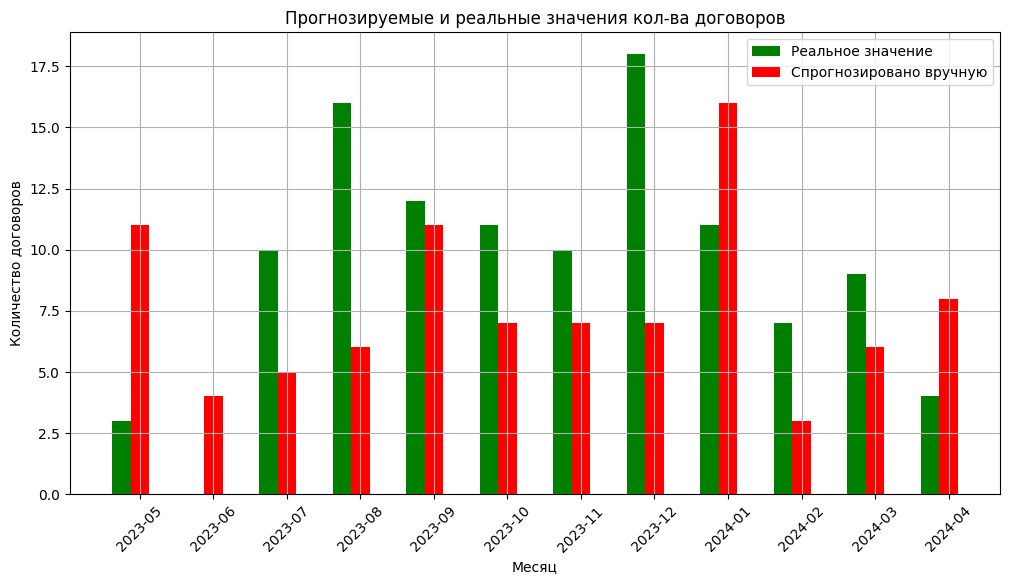

In [218]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Данные для примера
TMP = pd.date_range(start='2023-05-01', end='2024-04-30', periods=12).strftime('%Y-%m')  # Пример месяцев

# Создание графика
plt.figure(figsize=(12, 6))

# Построение графиков для каждого массива с разными цветами
AtualArray = np.array(actualCheck)
CasualPredictedArray = np.round((PR[-12:].values+PR[-24:-12].values)/2).reshape(12)
NNPredictedArray = np.round(np.array(predictedCheck).reshape(12,1)).reshape(12)

bar_width = 0.25  # Ширина столбиков
index = np.arange(len(TMP))  # Позиции для столбиков

# Построение столбиков
plt.bar(index, AtualArray, bar_width, color='green', label='Реальное значение')
plt.bar(index + bar_width, CasualPredictedArray, bar_width, color='red', label='Спрогнозировано вручную')
#plt.bar(index + 2 * bar_width, NNPredictedArray, bar_width, color='blue', label='Спрогнозировано нейросетью')

# Настройка графика
plt.title('Прогнозируемые и реальные значения кол-ва договоров')
plt.xlabel('Месяц')
plt.ylabel('Количество договоров')
plt.xticks(index + bar_width, TMP, rotation=45)  # Установка меток по оси X с поворотом
plt.legend()
plt.grid(True)

# Отображение графика
plt.show()

In [478]:
mape

0.9013905

In [493]:
np.mean(np.abs((np.array(actualCheck) - np.array(predictedCheck)) / actualCheck)) 

C:\Users\LEONSAM\AppData\Local\Temp\ipykernel_21392\3195733860.py:1: RuntimeWarning: divide by zero encountered in divide
  np.mean(np.abs((np.array(actualCheck) - np.array(predictedCheck)) / actualCheck))


inf

In [495]:
mask = actualCheck != 0
predicted_filtered = predictedCheck[mask]
actual_filtered = actualCheck[mask]
mape = np.mean(np.abs((actual_filtered - predicted_filtered) / actual_filtered)) * 100
print(f'Средняя абсолютная процентная ошибка (MAPE): {mape:.2f}%')

Средняя абсолютная процентная ошибка (MAPE): 57.89%


In [199]:
# Пример массивов предсказанных и реальных значений
predicted = CasualPredictedArray #np.array(predictedCheck)
actual =  AtualArray 

# Удаление элементов с нулевыми значениями в actual для MAPE и sMAPE
mask = actual != 0
predicted_filtered = predicted[mask]
actual_filtered = actual[mask]

# Средняя абсолютная процентная ошибка (MAPE)
mape = np.mean(np.abs((actual_filtered - predicted_filtered) / actual_filtered)) * 100

# Симметричная средняя абсолютная процентная ошибка (sMAPE)
smape = np.mean(2 * np.abs(actual_filtered - predicted_filtered) / (np.abs(actual_filtered) + np.abs(predicted_filtered))) * 100

# Процент точных предсказаний (например, в пределах 10% от реального значения)
tolerance = 0.30
accurate_predictions = np.mean(np.abs((actual_filtered - predicted_filtered) / actual_filtered) < tolerance) * 100

print(f'Средняя абсолютная процентная ошибка (MAPE): {mape:.2f}%')
print(f'Симметричная средняя абсолютная процентная ошибка (sMAPE): {smape:.2f}%')
print(f'Процент точных предсказаний (в пределах {tolerance*100}%): {accurate_predictions:.2f}%')

Средняя абсолютная процентная ошибка (MAPE): 68.26%
Симметричная средняя абсолютная процентная ошибка (sMAPE): 61.09%
Процент точных предсказаний (в пределах 30.0%): 9.09%


In [200]:
predicted = NNPredictedArray
actual =  AtualArray
# Удаление элементов с нулевыми значениями в actual для MAPE и sMAPE
mask = actual != 0
predicted_filtered = predicted[mask]
actual_filtered = actual[mask]
# Средняя абсолютная процентная ошибка (MAPE)
mape = np.mean(np.abs((actual_filtered - predicted_filtered) / actual_filtered)) * 100
# Симметричная средняя абсолютная процентная ошибка (sMAPE)
smape = np.mean(2 * np.abs(actual_filtered - predicted_filtered) / (np.abs(actual_filtered) + np.abs(predicted_filtered))) * 100
# Процент точных предсказаний 
tolerance = 0.30
accurate_predictions = np.mean(np.abs((actual_filtered - predicted_filtered) / actual_filtered) < tolerance) * 100
print(f'Средняя абсолютная процентная ошибка (MAPE): {mape:.2f}%')
print(f'Симметричная средняя абсолютная процентная ошибка (sMAPE): {smape:.2f}%')
print(f'Процент точных предсказаний (в пределах {tolerance*100}%): {accurate_predictions:.2f}%')

Средняя абсолютная процентная ошибка (MAPE): 39.42%
Симметричная средняя абсолютная процентная ошибка (sMAPE): 37.88%
Процент точных предсказаний (в пределах 30.0%): 54.55%


In [137]:
CasualPredictedArray

array([[11.],
       [ 4.],
       [ 5.],
       [ 6.],
       [11.],
       [ 7.],
       [ 7.],
       [ 7.],
       [16.],
       [ 3.],
       [ 6.],
       [ 8.]], dtype=float32)

,CountContracts,c
Unnamed: 0,,
2013-01-01,0.0,0.0
2013-01-02,0.0,0.0
2013-01-03,0.0,0.0
2013-01-04,0.0,13.0
2013-01-05,0.0,15.0
...,...,...
2024-04-26,0.0,1.0
2024-04-27,1.0,0.0
2024-04-28,0.0,2.0


In [179]:
import numpy as np
f = df[['CountContracts', 'OneRoomRemainMore37']]
# Предположим, у нас есть данные о количестве звонков и количество заключаемых договоров за последние 60 дней
calls = f[['OneRoomRemainMore37']].values  # Значения количества звонков
contracts = f[['CountContracts']].values  # Значения количества заключаемых договоров

# Подсчет средних значений
mean_calls = np.mean(calls)
mean_contracts = np.mean(contracts)



In [180]:
# Вычисление оценки коэффициента beta_1
numerator = np.sum((calls - mean_calls) * (contracts - mean_contracts))
denominator = np.sum((calls - mean_calls) ** 2)
beta_1_hat = numerator / denominator

print("Оценка коэффициента beta_1:", beta_1_hat)

Оценка коэффициента beta_1: -7.936491e-06
